**Preprocessing**

In [1]:

%load_ext autoreload
%autoreload 2
# Imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import shap
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from dataclasses import dataclass
from typing import List, Dict, Any, Set
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    average_precision_score
)
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, label_binarize
)

data = pd.read_csv(f"data/train.csv")

**Split the data**

In [2]:
# Split and preprocess fixed variables
SEED = 42

PCA_CUTOFF = 0.95

NUM_FOLDS = 3

ORDINAL_FEATURES = {
    "FGC-FGC_CU_Zone": [-1, 0, 1],
    "FGC-FGC_GSND_Zone": [-1, 1, 2, 3],
    "FGC-FGC_GSD_Zone": [-1, 1, 2, 3],
    "FGC-FGC_PU_Zone": [-1, 0, 1],
    "FGC-FGC_SRR_Zone": [-1, 0, 1],
    "FGC-FGC_TL_Zone": [-1, 0, 1],
    "BIA-BIA_Activity_Level_num": [-1, 1, 2, 3, 4, 5],
    "BIA-BIA_Frame_num": [-1, 1, 2, 3],
    "PreInt_EduHx-computerinternet_hoursday": [-1, 0, 1, 2, 3]
}

AGE_BUCKETS = {
    0: {5, 6, 7, 8, 9},
    1: {10, 11, 12, 13},
    2: {14, 15, 16, 17},
    3: {18, 19, 20, 21, 22}
}

# Set random seeds
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


def get_data_types() -> Dict[str, List[str]]:
    # Read in data descriptions
    data_descriptions = pd.read_csv(f"data/data_dictionary.csv")

    cont_columns = []
    cat_columns = ["sii"]
    for _, row in data_descriptions.iterrows():
        if row.Type == "float" or row.Type == "int":
            cont_columns.append(row.Field)

        if row.Type == "categorical int":
            cat_columns.append(row.Field)

        if row.Type == "str" and row.Values is not np.nan:
            cat_columns.append(row.Field)

    return {
        "cont_columns": cont_columns,
        "cat_columns": cat_columns
    }

DATA_TYPES: Dict[str, List[str]] = get_data_types()

In [3]:
original_size = len(data)

# Get the true categorical labels
true_labels = {}
for _, row in data.iterrows():
    true_labels[row["id"]] = row["sii"]

# Drop rows with missing `sii` data
data.dropna(subset=["sii"], inplace=True)
print(f"Dropped {original_size - len(data)} rows out of {original_size} with missing `sii` data")

# Check which data points also have timeseries data
has_timeseries = set()
for file_name in os.listdir(f"data/series_train.parquet"):
    if file_name.startswith("id="):
        has_timeseries.add(file_name[3:])
data["has_timeseries"] = data["id"].apply(lambda x: x in has_timeseries)

# Add age_group for stratification
data["age_group"] = data["Basic_Demos-Age"].apply(
    lambda x: next((k for k, v in AGE_BUCKETS.items() if x in v), -1)
)

# Make the stratification target
data["stratify_target"] = (
    data["sii"].astype(str) + "|"
    + data["has_timeseries"].astype(str) + "|"
    + data["age_group"].astype(str) + "|"
    + data["Basic_Demos-Sex"].astype(str)
)

stratify_counts = data["stratify_target"].value_counts()
while min(stratify_counts.values) < 5 * NUM_FOLDS:
    # Union all groups with less samples than the number of folds
    data["stratify_target"] = data["stratify_target"].apply(
        lambda x: x if stratify_counts[x] > 5 * NUM_FOLDS else "union"
    )
    stratify_counts = data["stratify_target"].value_counts()

# Preprocessed data
preprocessed_data = data.copy()

Dropped 1224 rows out of 3960 with missing `sii` data


**K-Folds**

In [4]:
@dataclass
class SplitData:
    train_X: List[pd.DataFrame]
    val_X: List[pd.DataFrame]
    test_X:  pd.DataFrame
    train_y: pd.Series
    val_y: pd.Series
    test_y: pd.Series
    true_labels: Dict[str, int]
    full: pd.DataFrame


def split(data: pd.DataFrame) -> SplitData:

    # Split stratify the data
    X = data
    y = data["stratify_target"]
    other_X, test_X, other_y, test_y = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=SEED,
        stratify=y,
    )

    train_X, val_X = [], []
    train_y, val_y = [], []

    if NUM_FOLDS > 1:
        other_y = other_X["PCIAT-PCIAT_Total"]
        other_stratify_target = other_X["stratify_target"]
        test_y = test_X["PCIAT-PCIAT_Total"]

        to_drop = ["age_group", "has_timeseries", "stratify_target"]
        for col in other_X.columns:
            if (col.startswith("PCIAT") and not col.endswith("Total")) or col.startswith("sii"):
                to_drop.append(col)
        other_X.drop(columns=to_drop, inplace=True)
        test_X.drop(columns=to_drop, inplace=True)

        skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)

        for train_index, val_index in skf.split(other_X, other_stratify_target):
            train_X.append(other_X.iloc[train_index])
            val_X.append(other_X.iloc[val_index])
            train_y.append(other_y.iloc[train_index])
            val_y.append(other_y.iloc[val_index])

        for fold in range(len(train_X)):
            assert len(train_X[fold]) == len(train_y[fold])
            assert len(val_X[fold]) == len(val_y[fold])
            assert len(test_X) == len(test_y)

            assert len(train_X[fold]) + len(val_X[fold]) + len(test_X) == len(X)
            assert abs(len(train_X[fold]) - (1 - 1 / NUM_FOLDS) * len(X) * (1 - 0.2)) < 2

        split_data = SplitData(
            train_X=train_X,
            val_X=val_X,
            test_X=test_X,
            train_y=train_y,
            val_y=val_y,
            test_y=test_y,
            true_labels=true_labels,
            full=X,
        )
    else:
        train_X, val_X, _, _ = train_test_split(
            other_X,
            other_y,
            test_size=0.2,
            random_state=SEED,
            stratify=other_y,
        )

        train_y = train_X["PCIAT-PCIAT_Total"]
        val_y = val_X["PCIAT-PCIAT_Total"]
        test_y = test_X["PCIAT-PCIAT_Total"]
        to_drop = ["age_group", "has_timeseries", "stratify_target"]
        for col in train_X.columns:
            if (col.startswith("PCIAT") and not col.endswith("Total")) or col.startswith("sii"):
                to_drop.append(col)
        train_X.drop(columns=to_drop, inplace=True)
        val_X.drop(columns=to_drop, inplace=True)
        test_X.drop(columns=to_drop, inplace=True)

        split_data = SplitData(
            train_X=train_X,
            val_X=val_X,
            test_X=test_X,
            train_y=train_y,
            val_y=val_y,
            test_y=test_y,
            true_labels=true_labels,
            full=X,
        )
    return split_data

split_data = split(preprocessed_data.copy())

print(f"Num train sets: {len(split_data.train_X)}")


Num train sets: 3


**Load in timeseries data**

In [5]:
def gen_timeseries_summary_data(df: pd.DataFrame, t: str):
    """Generates a dataframe of summary statistics data from timeseries data"""
    summary_data = []
    print(f"Generating timeseries summary data for {t}")
    for id, group in df.groupby("id"):
        summary_data.append({
            "id": id,
            f"{t}_light_median": group["light"].median(),
            f"{t}_light_std": group["light"].std(),
            f"{t}_light_min": group["light"].min(),
            f"{t}_light_max": group["light"].max(),
            f"{t}_light_25": group["light"].quantile(0.25),
            f"{t}_light_50": group["light"].quantile(0.50),
            f"{t}_light_75": group["light"].quantile(0.75),
            f"{t}_light_90": group["light"].quantile(0.90),
            f"{t}_anglez_median": group["anglez"].median(),
            f"{t}_anglez_std": group["anglez"].std(),
            f"{t}_anglez_min": group["anglez"].min(),
            f"{t}_anglez_max": group["anglez"].max(),
            f"{t}_anglez_25": group["anglez"].quantile(0.25),
            f"{t}_anglez_50": group["anglez"].quantile(0.50),
            f"{t}_anglez_75": group["anglez"].quantile(0.75),
            f"{t}_anglez_90": group["anglez"].quantile(0.90),
            f"{t}_enmo_median": group["enmo"].median(),
            f"{t}_enmo_std": group["enmo"].std(),
            f"{t}_enmo_min": group["enmo"].min(),
            f"{t}_enmo_max": group["enmo"].max(),
            f"{t}_enmo_25": group["enmo"].quantile(0.25),
            f"{t}_enmo_50": group["enmo"].quantile(0.50),
            f"{t}_enmo_75": group["enmo"].quantile(0.75),
            f"{t}_enmo_90": group["enmo"].quantile(0.90),
        })

    return pd.DataFrame(summary_data).reset_index(drop=True)


def read_timeseries(file_name, dir_name):
    """Reads in a timeseries parquet file and returns a dataframe"""
    df = pd.read_parquet(
        os.path.join(dir_name, file_name, "part-0.parquet"),
        "fastparquet",
    )
    df["daytime"] = df["time_of_day"].apply(lambda x: x / 3_600_000_000_000)
    df["id"] = file_name.split("=")[1]
    return df

results = []
for file_name in tqdm(
    os.listdir("data/series_train.parquet"),
    desc="Loading timeseries data"
):
    if file_name.startswith("id="):
        results.append(read_timeseries(
            file_name, f"data/series_train.parquet"
        ))

timeseries_df = pd.concat(results)[
    [
        "id", "daytime", "weekday",
        "light", "anglez", "enmo", "non-wear_flag"
    ]
]
timeseries_df = timeseries_df[timeseries_df["non-wear_flag"] == 0]
del results

# Getting summary stats for timeseries split by weekday and weekend
weekday_df = gen_timeseries_summary_data(
    timeseries_df[timeseries_df["weekday"].isin([0, 1, 2, 3, 4])],
    "weekday"
)
weekend_df = gen_timeseries_summary_data(
    timeseries_df[timeseries_df["weekday"].isin([5, 6])],
    "weekend"
)

timeseries_df = pd.merge(weekend_df, weekday_df, on="id")
del weekday_df
del weekend_df

Loading timeseries data: 100%|██████████| 997/997 [00:39<00:00, 24.98it/s]


Generating timeseries summary data for weekday
Generating timeseries summary data for weekend


**Exclude highly correlated continuous columns (>0.95)**

In [6]:
def cont_cols_to_exclude(data: pd.DataFrame, corr_threshold: float = 0.95) -> Set:
    correlation_matrix: pd.DataFrame = data.corr()

    column_pair_cnts: Dict[str, int] = {}
    correlated_pair_counts: int = 0
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            col1: str = correlation_matrix.columns[i]
            col2: str = correlation_matrix.columns[j]
            correlation: float = correlation_matrix.loc[col1, col2]
            if abs(correlation) > corr_threshold:
                correlated_pair_counts += 1
                column_pair_cnts[col1] = column_pair_cnts.get(col1, 0) + 1
                column_pair_cnts[col2] = column_pair_cnts.get(col2, 0) + 1

    print(f"Number of correlated pairs: {correlated_pair_counts}")
    print(f"Number of columns with correlated pairs: {len(column_pair_cnts)}")

    to_exclude: Set = set()
    to_return: Set = set()
    to_exclude.add("PCIAT-PCIAT_Total")
    prev: int = correlated_pair_counts

    # Greedy search for minimum columns to remove to remove all highly correlated
    # column pairs
    while len(column_pair_cnts) > 0:
        max_column: str = max(column_pair_cnts, key=column_pair_cnts.get)
        if column_pair_cnts[max_column] == 0:
            break
        del column_pair_cnts[max_column]

        to_exclude.add(max_column)
        corr_pair_count: int = 0
        for i in range(len(correlation_matrix.columns)):
            for j in range(i + 1, len(correlation_matrix.columns)):
                col1: str = correlation_matrix.columns[i]
                col2: str = correlation_matrix.columns[j]

                # Skip already excluded columns
                if col1 in to_exclude or col2 in to_exclude:
                    continue

                if abs(correlation_matrix.loc[col1, col2]) > corr_threshold:
                    corr_pair_count += 1

                # If not change in the number of correlated pairs, keep the column
        if corr_pair_count == prev:
            to_return.add(max_column)
        if corr_pair_count == 0: break
        prev = corr_pair_count

    return list(to_exclude)

to_exclude = cont_cols_to_exclude(
    split_data.full[DATA_TYPES["cont_columns"]]
)
to_exclude.extend(
    cont_cols_to_exclude(timeseries_df.drop(columns=["id"]))
)
to_exclude.append("id")
print(f"Excluding {len(to_exclude)} columns")

Number of correlated pairs: 57
Number of columns with correlated pairs: 15
Number of correlated pairs: 6
Number of columns with correlated pairs: 12
Excluding 28 columns


In [7]:
# filtered_cont_columns = [
#     col for col in split_data.X.columns if col not in DATA_TYPES["cat_columns"]
# ]
# one_hot = [
#     col for col in split_data.X.columns
#     if col in DATA_TYPES["cat_columns"] and col not in ORDINAL_FEATURES
# ]
# ordinal = [
#     col for col in split_data.X.columns
#     if col in DATA_TYPES["cat_columns"] and col in ORDINAL_FEATURES
# ]

# min_max, std_scaler = [], [], 
# for col in filtered_cont_columns:
#     if "anglez_" in col:
#         min_max.append(col)
#     elif col == "Basic_Demos-Age":
#         one_hot.append(col)
#     else:
#         std_scaler.append(col)

# Calculated from the code above but is the same across all folds
one_hot = [
    "Basic_Demos-Enroll_Season", "Basic_Demos-Sex", "CGAS-Season",
    "Physical-Season", "Fitness_Endurance-Season", "FGC-Season",
    "FGC-FGC_SRL_Zone", "BIA-Season", "PAQ_A-Season", "PAQ_C-Season",
    "SDS-Season", "PreInt_EduHx-Season", "Basic_Demos-Age"
]
ordinal = [
    "FGC-FGC_CU_Zone", "FGC-FGC_GSND_Zone", "FGC-FGC_GSD_Zone",
    "FGC-FGC_PU_Zone", "FGC-FGC_SRR_Zone", "FGC-FGC_TL_Zone",
    "BIA-BIA_Activity_Level_num", "BIA-BIA_Frame_num",
    "PreInt_EduHx-computerinternet_hoursday"
]
min_max = [
    "weekend_anglez_std", "weekend_anglez_min", "weekend_anglez_max",
    "weekend_anglez_25", "weekend_anglez_75", "weekend_anglez_90",
    "weekday_anglez_std", "weekday_anglez_min", "weekday_anglez_max",
    "weekday_anglez_25", "weekday_anglez_75", "weekday_anglez_90"
]
std_scaler = [
    "CGAS-CGAS_Score", "Physical-Height", "Physical-Weight",
    "Physical-Waist_Circumference", "Physical-Diastolic_BP",
    "Physical-HeartRate", "Physical-Systolic_BP",
    "Fitness_Endurance-Max_Stage", "Fitness_Endurance-Time_Mins",
    "Fitness_Endurance-Time_Sec", "FGC-FGC_CU", "FGC-FGC_GSND",
    "FGC-FGC_GSD", "FGC-FGC_PU", "FGC-FGC_SRL", "FGC-FGC_SRR",
    "FGC-FGC_TL", "BIA-BIA_FFMI", "BIA-BIA_FMI", "PAQ_A-PAQ_A_Total",
    "PAQ_C-PAQ_C_Total", "SDS-SDS_Total_T", "weekend_light_std",
    "weekend_light_min", "weekend_light_max", "weekend_light_25",
    "weekend_light_75", "weekend_light_90", "weekend_enmo_std",
    "weekend_enmo_min", "weekend_enmo_max", "weekend_enmo_25",
    "weekend_enmo_75", "weekend_enmo_90", "weekday_light_std",
    "weekday_light_min", "weekday_light_max", "weekday_light_25",
    "weekday_light_75", "weekday_light_90", "weekday_enmo_std",
    "weekday_enmo_min", "weekday_enmo_max", "weekday_enmo_25",
    "weekday_enmo_50", "weekday_enmo_75", "weekday_enmo_90"
]

In [8]:
def transform_data(
    min_max: List[str], std_scaler: List[str], one_hot: List[str], ordinal: List[str],
    train_X: pd.DataFrame, val_X: pd.DataFrame, test_X: pd.DataFrame
):
    transformers = [
        ("min_max", MinMaxScaler(), min_max),
        ("std_scaler", StandardScaler(), std_scaler),
        ("one_hot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), one_hot)
    ]
    if len(ordinal) > 0:
        values = [ORDINAL_FEATURES[col] for col in ordinal]
        transformers.append(
            ("ordinal", OrdinalEncoder(categories=values), ordinal)
        )

    pipeline = ColumnTransformer(transformers, remainder="drop")

    # Fit pipeline
    train_X = pipeline.fit_transform(train_X)
    val_X = pipeline.transform(val_X)
    test_X = pipeline.transform(test_X)

    return train_X, val_X, test_X, pipeline

@dataclass
class FoldData:
    train_X: pd.DataFrame
    val_X: pd.DataFrame
    test_X: pd.DataFrame
    train_X_df: pd.DataFrame
    val_X_df: pd.DataFrame
    test_X_df: pd.DataFrame
    train_y: pd.Series
    val_y: pd.Series
    test_y: pd.Series
    to_exclude: List[str]
    to_include: List[str]
    true_labels: Dict[str, int]
    pipeline: ColumnTransformer

folds: List[FoldData] = []

for i in tqdm(range(len(split_data.train_X)), desc="Preprocessing folds"):
    train_X = split_data.train_X[i]
    val_X = split_data.val_X[i]
    train_y = split_data.train_y[i]
    val_y = split_data.val_y[i]

    # Timeseries columns to exclude
    train_X = pd.merge(
        train_X,
        timeseries_df[timeseries_df["id"].isin(train_X["id"])],
        on="id",
        how="left"
    )
    val_X = pd.merge(
        val_X,
        timeseries_df[timeseries_df["id"].isin(val_X["id"])],
        on="id",
        how="left"
    )
    test_X = pd.merge(
        split_data.test_X,
        timeseries_df[timeseries_df["id"].isin(split_data.test_X["id"])],
        on="id",
        how="left"
    )

    train_X.drop(columns=to_exclude, inplace=True, errors="ignore")
    val_X.drop(columns=to_exclude, inplace=True, errors="ignore")
    test_X.drop(columns=to_exclude, inplace=True, errors="ignore")

    
    # Fill missing values
    for col in min_max:
        mean = train_X[col].mean()
        train_X[col] = train_X[col].fillna(mean)
        val_X[col] = val_X[col].fillna(mean)
        test_X[col] = test_X[col].fillna(mean)
    for col in std_scaler:
        median = train_X[col].median()
        train_X[col] = train_X[col].fillna(median)
        val_X[col] = val_X[col].fillna(median)
        test_X[col] = test_X[col].fillna(median)
    for cols in [one_hot, ordinal]:
        for col in cols:
            if train_X[col].dtype in ["int64", "float64"]:
                train_X[col] = train_X[col].fillna(-1)
                val_X[col] = val_X[col].fillna(-1)
                test_X[col] = test_X[col].fillna(-1)
            elif train_X[col].dtype == "O":
                train_X[col] = train_X[col].fillna("missing")
                val_X[col] = val_X[col].fillna("missing")
                test_X[col] = test_X[col].fillna("missing")

    train_X_transformed, val_X_transformed, test_X_transformed, pipeline = transform_data(
        min_max, std_scaler, one_hot, ordinal, train_X, val_X, test_X
    )

    one_hot_features = pipeline.named_transformers_["one_hot"].get_feature_names_out(one_hot)
    all_features = list(one_hot_features) + ordinal + min_max + std_scaler

    # Convert transformed data to DataFrame
    df_train_transformed = pd.DataFrame(train_X_transformed, columns=all_features, index=train_X.index)
    df_val_transformed = pd.DataFrame(val_X_transformed, columns=all_features, index=val_X.index)
    df_test_transformed = pd.DataFrame(test_X_transformed, columns=all_features, index=test_X.index)

    # Correlation matrix of new one-hot encoded features
    # fig = plt.figure(figsize=(40, 40))
    # sns.heatmap(df_train_transformed[one_hot_features].corr().round(2), annot=True)
    # plt.show()
    # Also need to drop ['Basic_Demos-Age_14']
    # Sex not included since missing values lead to less than 0.95 correlation

    # Drop redundant features to avoid multicollinearity
    df_train_transformed.drop(columns=["Basic_Demos-Age_14"], inplace=True)
    df_val_transformed.drop(columns=["Basic_Demos-Age_14"], inplace=True)
    df_test_transformed.drop(columns=["Basic_Demos-Age_14"], inplace=True)

    # Convert back to numpy arrays
    train_X_transformed = df_train_transformed.values
    val_X_transformed = df_val_transformed.values
    test_X_transformed = df_test_transformed.values

    folds.append(
        FoldData(
            train_X=train_X_transformed,
            val_X=val_X_transformed,
            test_X=test_X_transformed,
            train_X_df=train_X,
            val_X_df=val_X,
            test_X_df=test_X,
            train_y=train_y,
            val_y=val_y,
            test_y=split_data.test_y,
            to_exclude=to_exclude,
            to_include=min_max + std_scaler + one_hot + ordinal,
            true_labels=split_data.true_labels,
            pipeline=pipeline
        )
    )

print()

# Check sizes of the splits
for fold in folds:
    # Print lengths of data in each fold as well as the list of columns to exclude
    print(f"Train: {len(fold.train_X)} Val: {len(fold.val_X)} Test: {len(fold.test_X)}")
    print(f"Columns to exclude: {len(fold.to_exclude)} - {fold.to_exclude}")
    print(f"Columns to include: {len(fold.to_include)} - {fold.to_include}")
    print()
    {len(fold.to_include)}

Preprocessing folds: 100%|██████████| 3/3 [00:00<00:00, 25.64it/s]


Train: 1458 Val: 730 Test: 548
Columns to exclude: 28 - ['BIA-BIA_DEE', 'BIA-BIA_BMR', 'BIA-BIA_LST', 'BIA-BIA_TBW', 'Physical-BMI', 'BIA-BIA_Fat', 'PCIAT-PCIAT_Total', 'BIA-BIA_ECW', 'BIA-BIA_BMC', 'BIA-BIA_ICW', 'BIA-BIA_FFM', 'BIA-BIA_SMM', 'BIA-BIA_LDM', 'SDS-SDS_Total_Raw', 'BIA-BIA_BMI', 'weekend_light_median', 'weekend_anglez_50', 'weekday_light_median', 'weekday_anglez_50', 'PCIAT-PCIAT_Total', 'weekend_enmo_50', 'weekend_light_50', 'weekday_light_50', 'weekday_enmo_median', 'weekend_anglez_median', 'weekend_enmo_median', 'weekday_anglez_median', 'id']
Columns to include: 81 - ['weekend_anglez_std', 'weekend_anglez_min', 'weekend_anglez_max', 'weekend_anglez_25', 'weekend_anglez_75', 'weekend_anglez_90', 'weekday_anglez_std', 'weekday_anglez_min', 'weekday_anglez_max', 'weekday_anglez_25', 'weekday_anglez_75', 'weekday_anglez_90', 'CGAS-CGAS_Score', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Sy

In [9]:
# Merge all train and validation data from the folds into a single dataset for evaluation
train_X_full = np.concatenate(
    [fold.train_X for fold in folds] + [fold.val_X for fold in folds]
)

train_X_full_df = pd.concat(
    [fold.train_X_df for fold in folds] + [fold.val_X_df for fold in folds]
)

train_y_full = pd.concat(
    [fold.train_y for fold in folds] + [fold.val_y for fold in folds]
)

**Machine Learning**

In [10]:

def bucketize(predictions, thresholds=[30, 50, 80]):
    """Map continuous values to discrete buckets."""
    return np.digitize(predictions, thresholds)


def quadratic_weighted_kappa(y_true, y_pred, num_buckets=4):
    """
    Compute the Quadratic Weighted Kappa (QWK) score.
    As defined here: https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/overview
    """
    O = np.zeros((num_buckets, num_buckets), dtype=np.float64)
    for i, j in zip(y_true, y_pred):
        O[i, j] += 1

    W = np.zeros((num_buckets, num_buckets), dtype=np.float64)
    for i in range(num_buckets):
        for j in range(num_buckets):
            W[i, j] = ((i - j) ** 2) / ((num_buckets - 1) ** 2)

    actual_hist = np.sum(O, axis=1)
    pred_hist = np.sum(O, axis=0)
    E = np.outer(actual_hist, pred_hist)
    E *= np.sum(O) / np.sum(E)
    assert abs(np.sum(O) - np.sum(E)) < 1e-6

    num = 0
    denom = 0
    for i in range(num_buckets):
        for j in range(num_buckets):
            num += W[i, j] * O[i, j]
            denom += W[i, j] * E[i, j]
    return 1 - num / denom


# Define the NeuralNetwork class
class NeuralNetwork:
    def __init__(self, layers, layer_sizes, activation, learning_rate, epochs, batch_size):
        self.layers = layers
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        for _ in range(self.layers):
            model.add(Dense(self.layer_sizes, activation=self.activation))
        model.add(Dense(1))
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss="mse")
        # model.compile(optimizer=optimizer, loss=QWKLoss(num_buckets=4))
        return model

    def fit(self, X, y, verbose=0):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=verbose)

    def predict(self, X, verbose=0):
        return self.model.predict(X, verbose=verbose).flatten()

    def score(self, X, y):
        # Calculate and return the R² score used for permutation importance scoring
        y_pred = self.predict(X)
        return r2_score(y, y_pred)


# Define the models for regression
models = {
    "LinearRegression": LinearRegression,
    "ElasticNet": ElasticNet,
    "KNN": KNeighborsRegressor,
    "XGBoost": XGBRegressor,
}

def plot_multiclass_roc(y_true, y_scores, n_classes, model_name):
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(12, 10))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.subplot(2, 2, i + 1)
        sns.lineplot(x=fpr[i], y=tpr[i], lw=2, label=f"ROC curve (area = {roc_auc[i]:.2f})", color="b")
        sns.lineplot(x=[0, 1], y=[0, 1], color="navy", lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"SII={i} ROC Curve")
        plt.legend(loc="lower right")
    plt.suptitle(f"Multiclass ROC Curves for {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"figures/{model_name}_auc_roc.png", dpi=300)
    plt.show()

def plot_multiclass_precision_recall(y_true, y_scores, n_classes, model_name):
    precision = {}
    recall = {}
    avg_precision = {}

    plt.figure(figsize=(12, 10))
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_scores[:, i])
        avg_precision[i] = average_precision_score(y_true[:, i], y_scores[:, i])

        plt.subplot(2, 2, i + 1)
        sns.lineplot(x=recall[i], y=precision[i], lw=2, label=f"AP = {avg_precision[i]:.2f}", color="g")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"SII={i} Precision-Recall Curve")
        plt.legend(loc="lower left")
    plt.suptitle(f"Multiclass Precision-Recall Curves for {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"figures/{model_name}_precision_recall_curve.png", dpi=300)
    plt.show()

Performing grid search for LinearRegression...
Params: {}, Mean Val QWK: 0.3771450838806909
Best Params for LinearRegression: {}
Full train QWK: 0.3771450838806909, Test QWK: 0.39912280701754377, Test RMSE: 17.987278054880118, Weighted F1 Score: 0.5514024825119266



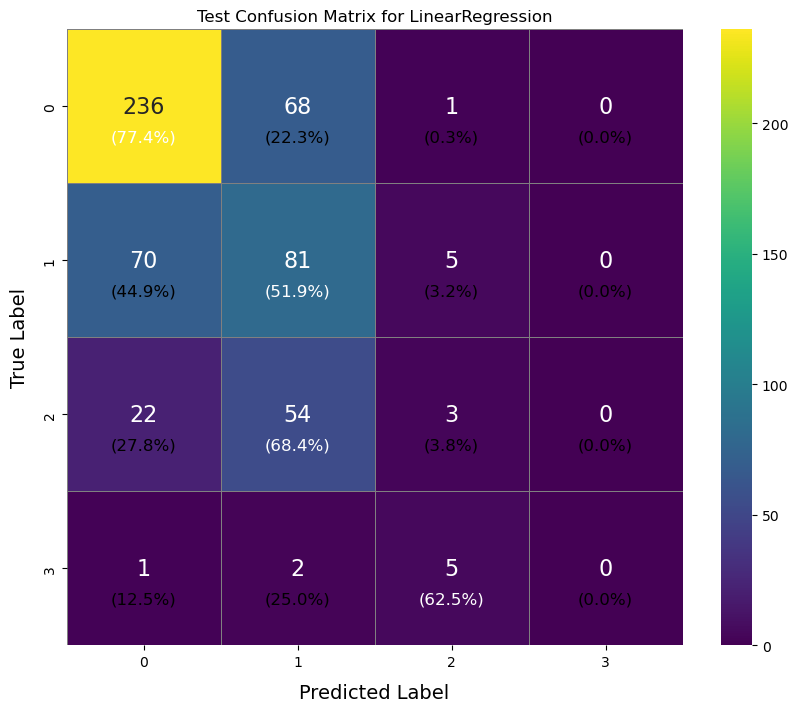

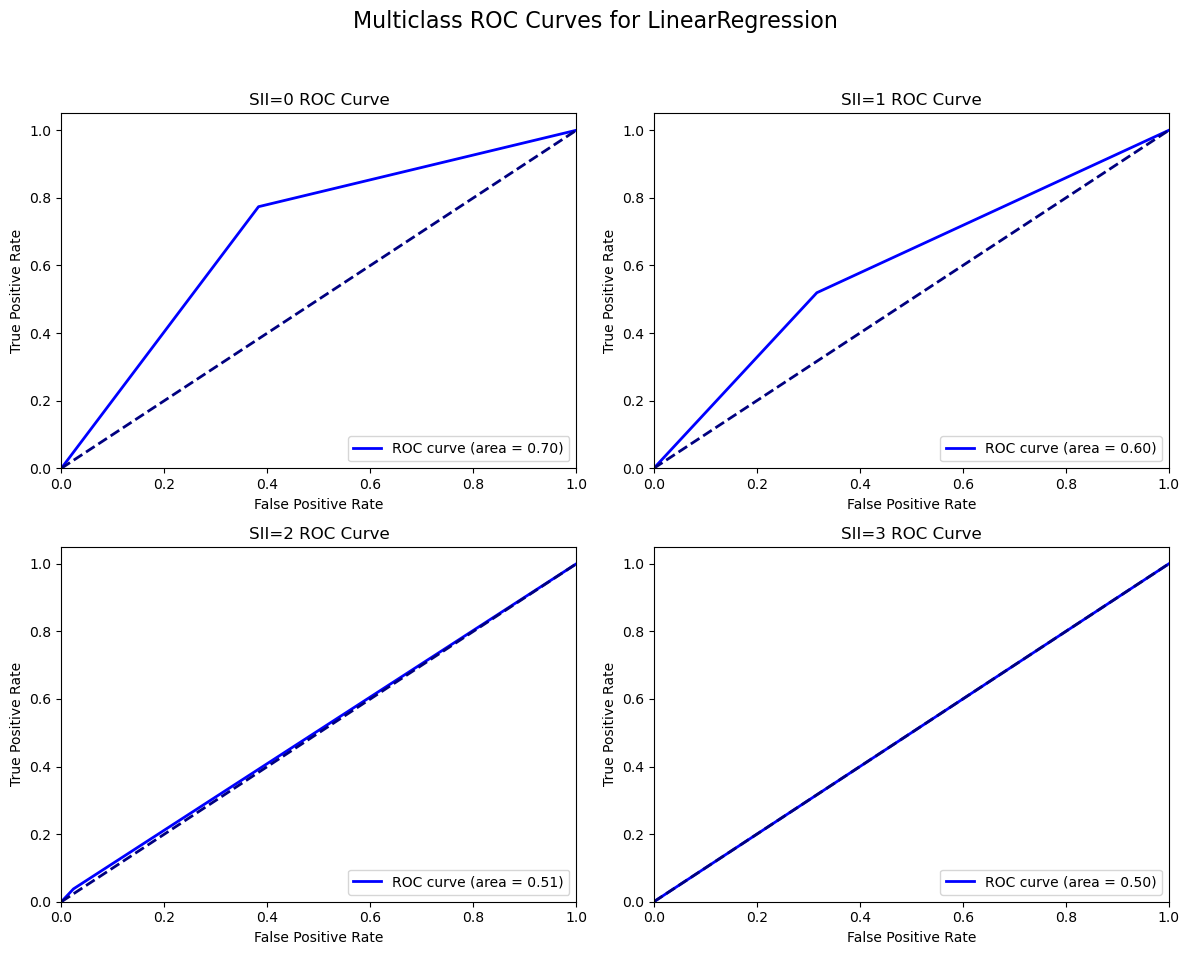

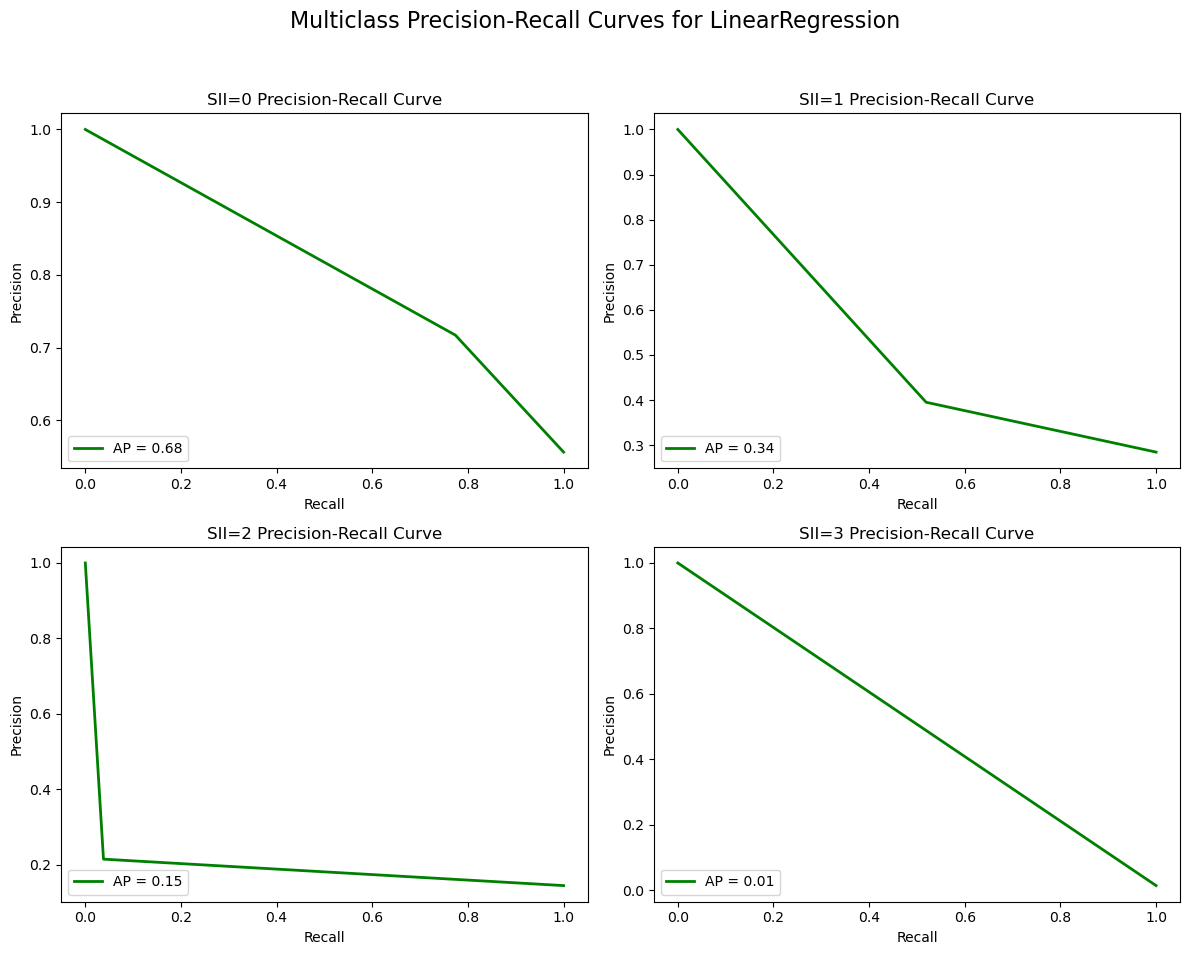


Performing grid search for ElasticNet...
Params: {'alpha': 0.1, 'l1_ratio': 0.1}, Mean Val QWK: 0.3834219855810847
Params: {'alpha': 0.1, 'l1_ratio': 0.5}, Mean Val QWK: 0.38725790921661285
Params: {'alpha': 0.1, 'l1_ratio': 0.9}, Mean Val QWK: 0.39161452498857957
Params: {'alpha': 0.5, 'l1_ratio': 0.1}, Mean Val QWK: 0.3675320969335276
Params: {'alpha': 0.5, 'l1_ratio': 0.5}, Mean Val QWK: 0.3712353468935136
Params: {'alpha': 0.5, 'l1_ratio': 0.9}, Mean Val QWK: 0.38070799603271577
Params: {'alpha': 1.0, 'l1_ratio': 0.1}, Mean Val QWK: 0.3478648236638529
Params: {'alpha': 1.0, 'l1_ratio': 0.5}, Mean Val QWK: 0.34350025741480916
Params: {'alpha': 1.0, 'l1_ratio': 0.9}, Mean Val QWK: 0.35682983539680624
Best Params for ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.9}
Full train QWK: 0.39161452498857957, Test QWK: 0.3912158481694904, Test RMSE: 17.809092154434655, Weighted F1 Score: 0.5609341193627105



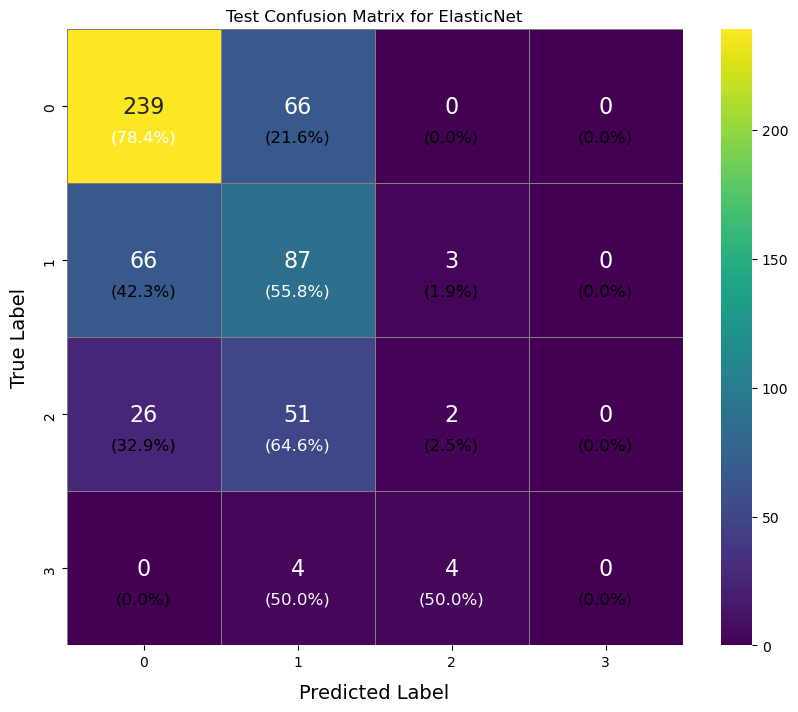

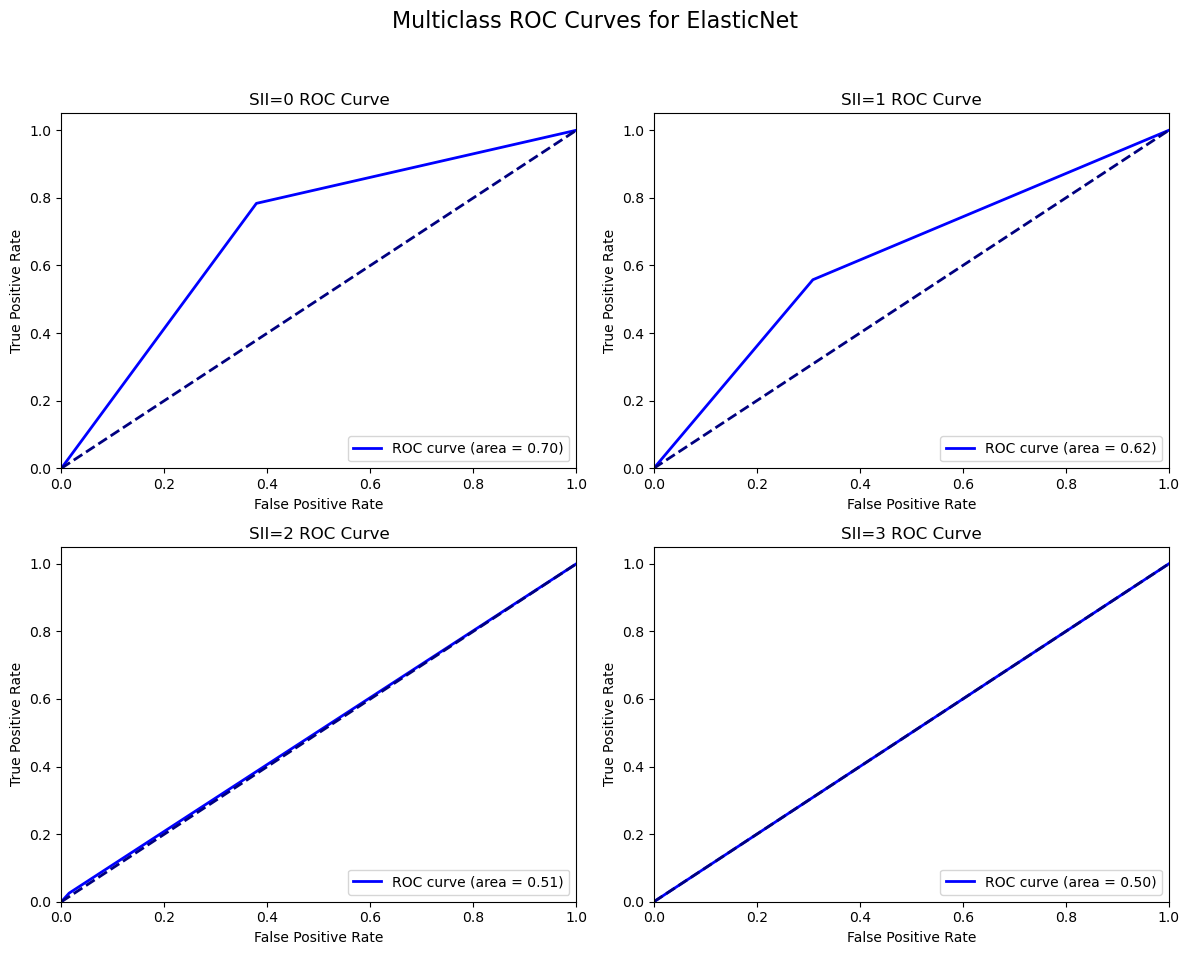

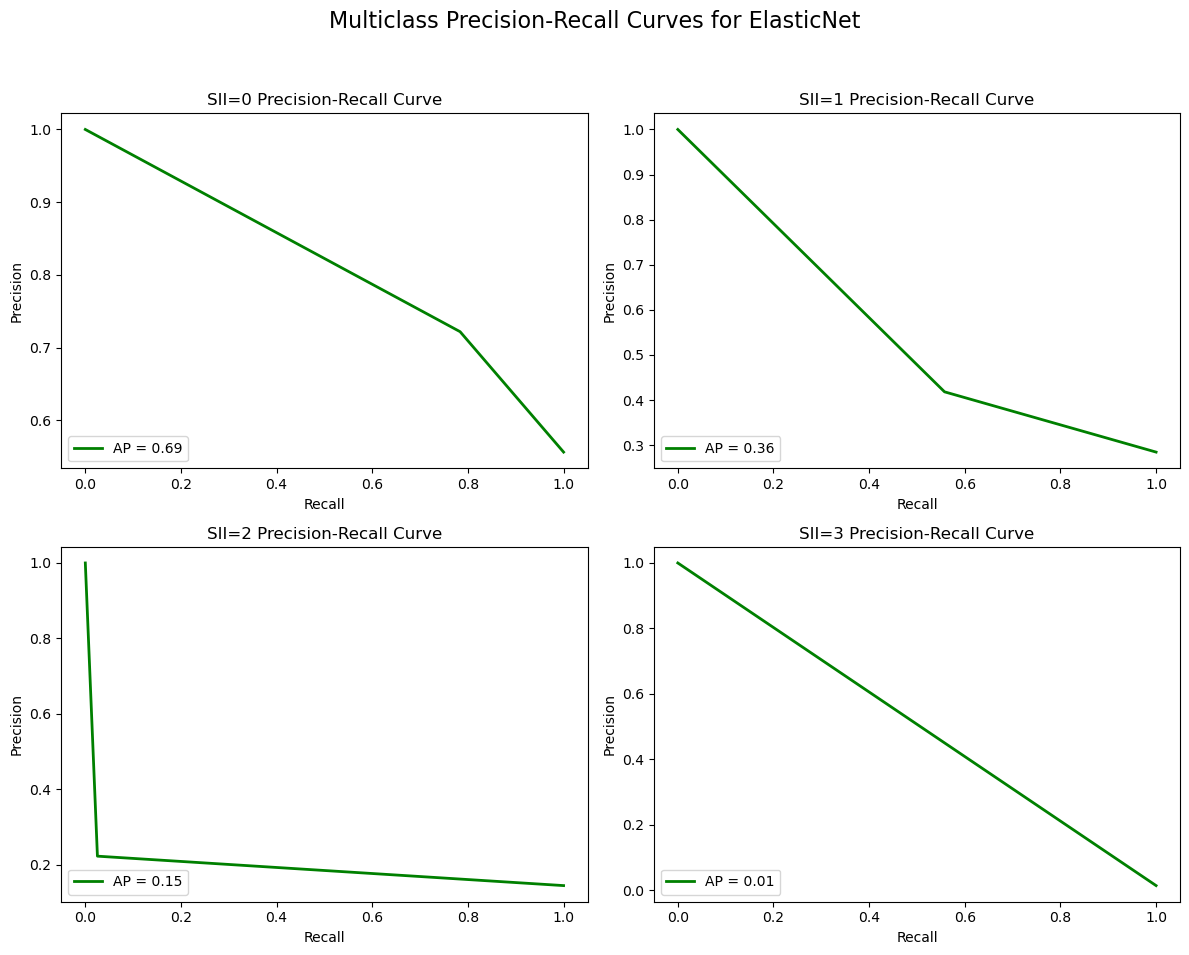


Performing grid search for KNN...
Params: {'n_neighbors': 3, 'weights': 'uniform'}, Mean Val QWK: 0.27692362565047574
Params: {'n_neighbors': 3, 'weights': 'distance'}, Mean Val QWK: 0.2681436074447871
Params: {'n_neighbors': 5, 'weights': 'uniform'}, Mean Val QWK: 0.3039536737846192
Params: {'n_neighbors': 5, 'weights': 'distance'}, Mean Val QWK: 0.3048249556736983
Params: {'n_neighbors': 10, 'weights': 'uniform'}, Mean Val QWK: 0.28212367589647397
Params: {'n_neighbors': 10, 'weights': 'distance'}, Mean Val QWK: 0.28636136074106444
Best Params for KNN: {'n_neighbors': 5, 'weights': 'distance'}
Full train QWK: 0.3048249556736983, Test QWK: 0.30232617652327454, Test RMSE: 21.51989599482019, Weighted F1 Score: 0.525033645249306



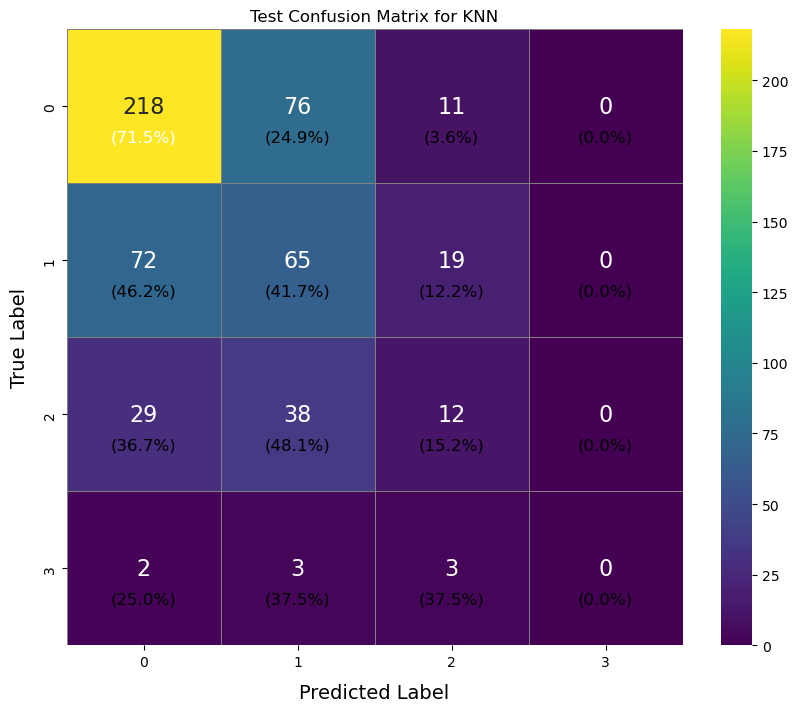

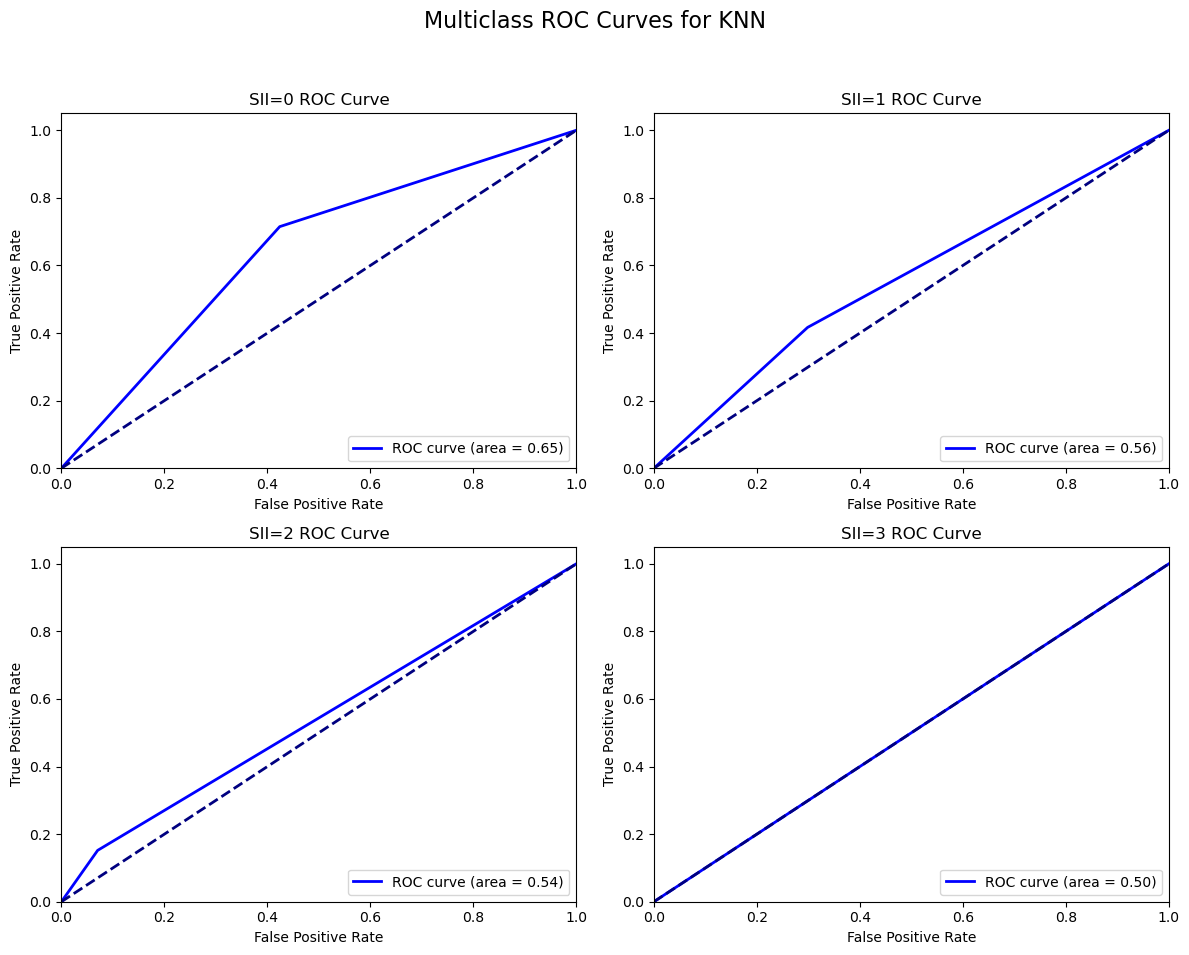

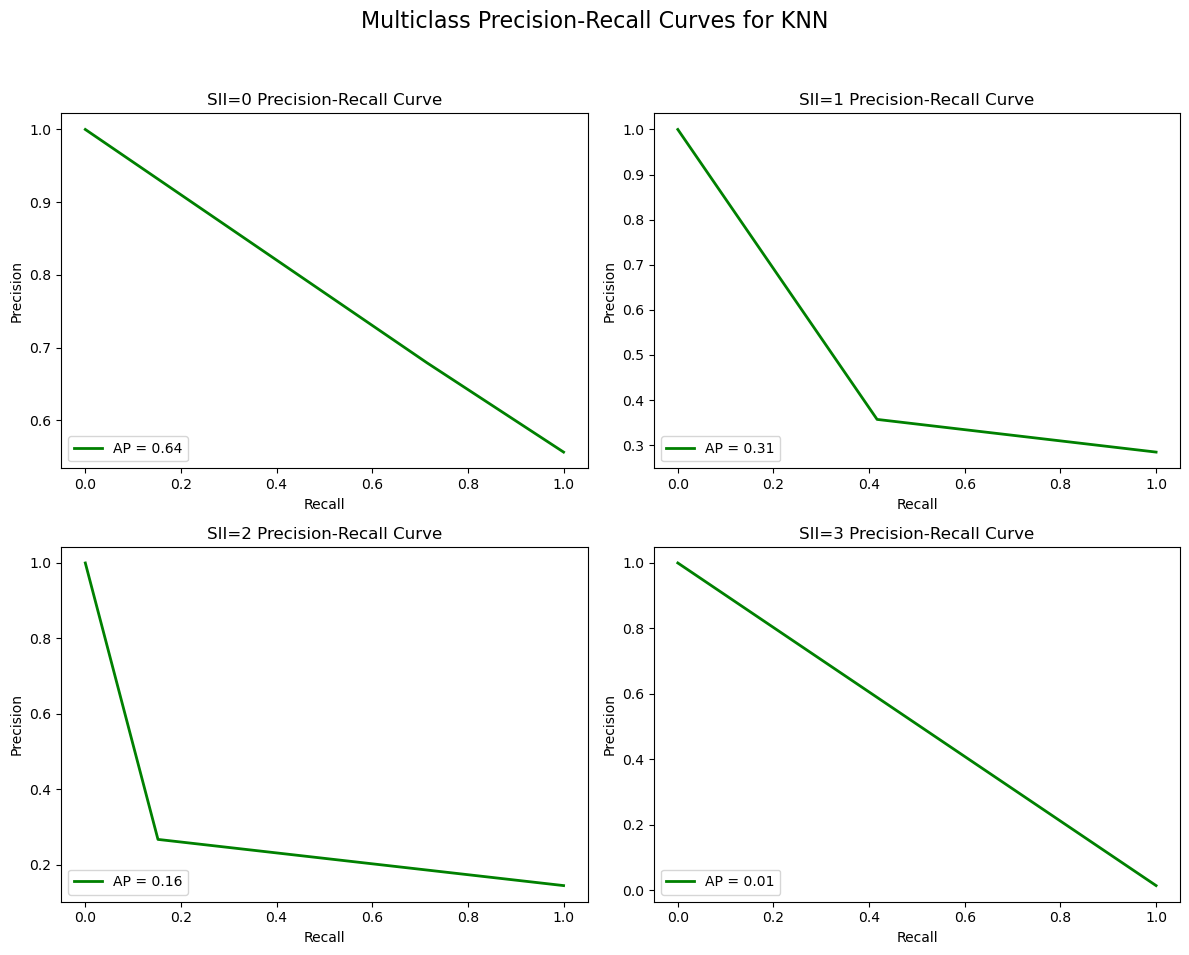


Performing grid search for XGBoost...
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}, Mean Val QWK: 0.38424103535746973
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0}, Mean Val QWK: 0.38129383233791553
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}, Mean Val QWK: 0.35167714123757565
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 1.0}, Mean Val QWK: 0.34527368684346094
Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}, Mean Val QWK: 0.377800252063407
Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0}, Mean Val QWK: 0.37069673297355493
Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}, Mean Val QWK: 0.3562677124719266
Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 1.0}, Mean Val QWK: 0.3482950439791292
P

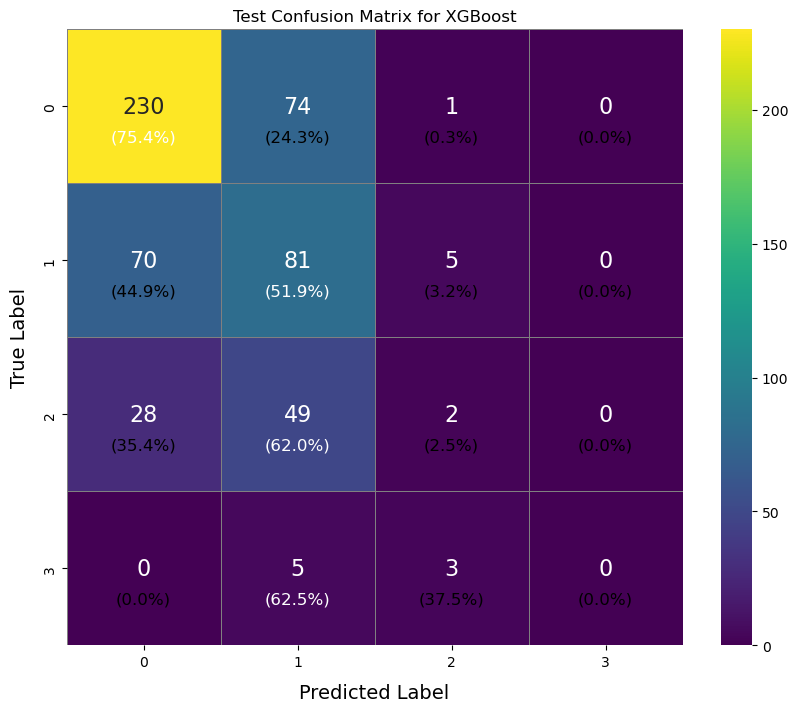

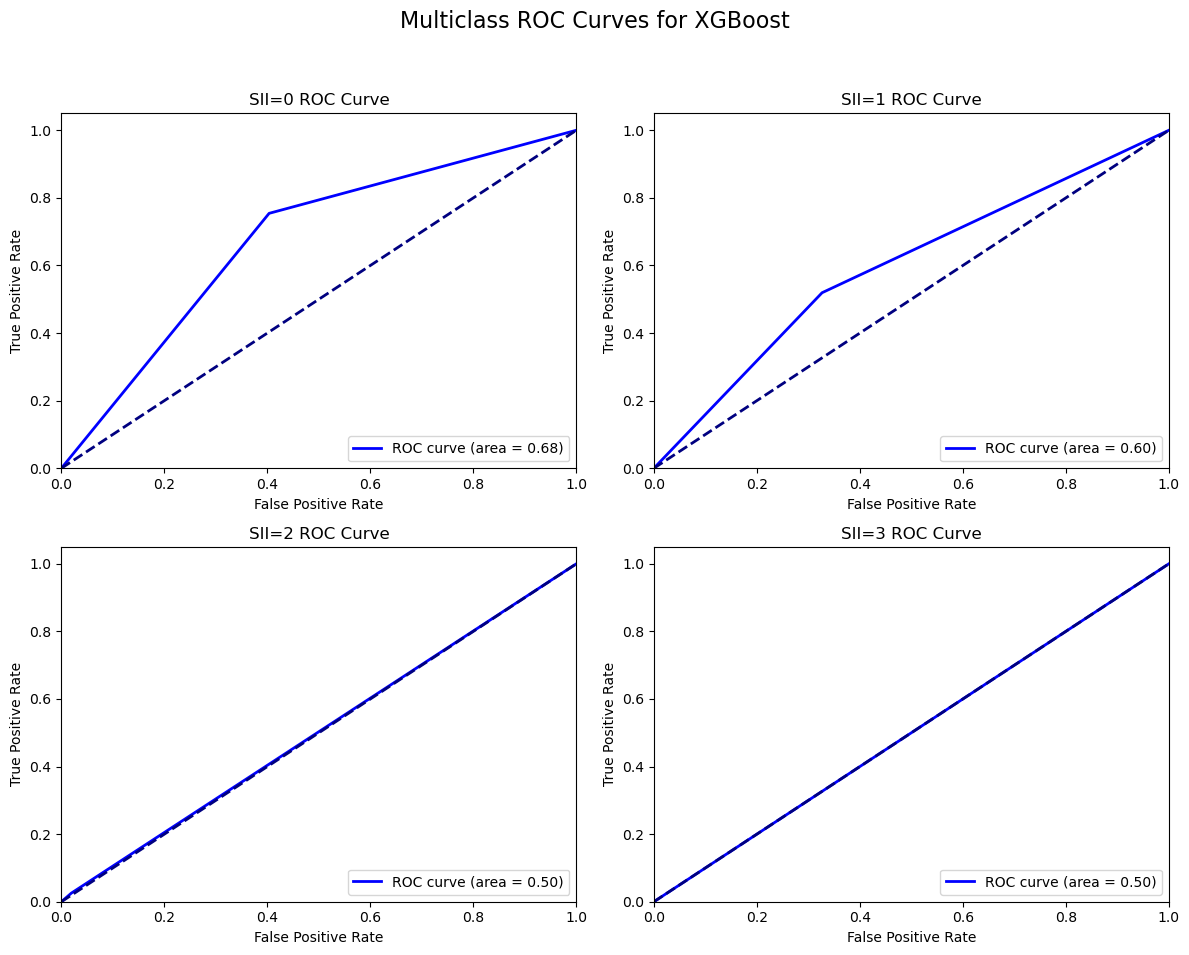

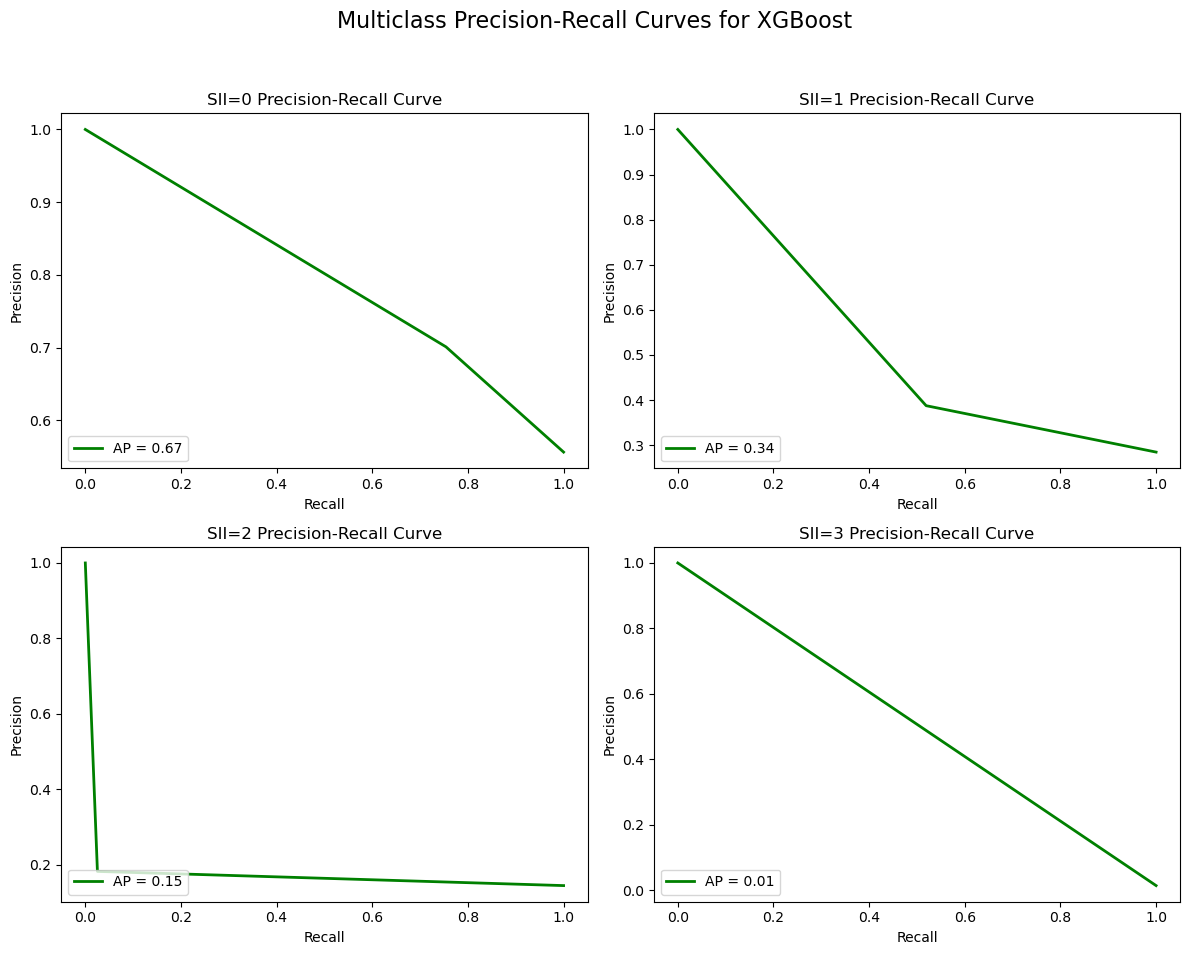


Performing grid search for NeuralNetwork...
Params: {'layers': 1, 'layer_sizes': 4, 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 5, 'batch_size': 8}, Mean Val QWK: 0.26766096295197916
Params: {'layers': 1, 'layer_sizes': 4, 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 5, 'batch_size': 16}, Mean Val QWK: 0.0716616658271096
Params: {'layers': 1, 'layer_sizes': 4, 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 5, 'batch_size': 32}, Mean Val QWK: 0.006392919889898874
Params: {'layers': 1, 'layer_sizes': 4, 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 8}, Mean Val QWK: 0.30647417410599587
Params: {'layers': 1, 'layer_sizes': 4, 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 16}, Mean Val QWK: 0.24420264461834684
Params: {'layers': 1, 'layer_sizes': 4, 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 32}, Mean Val QWK: 0.10491117491852575
Params: {'layers': 1, 'layer_sizes': 4, 'a

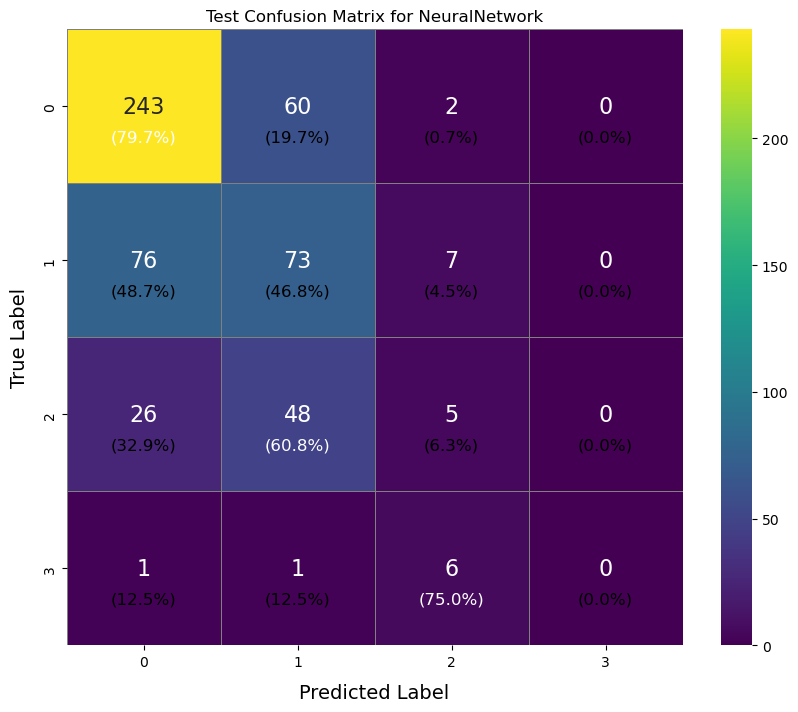

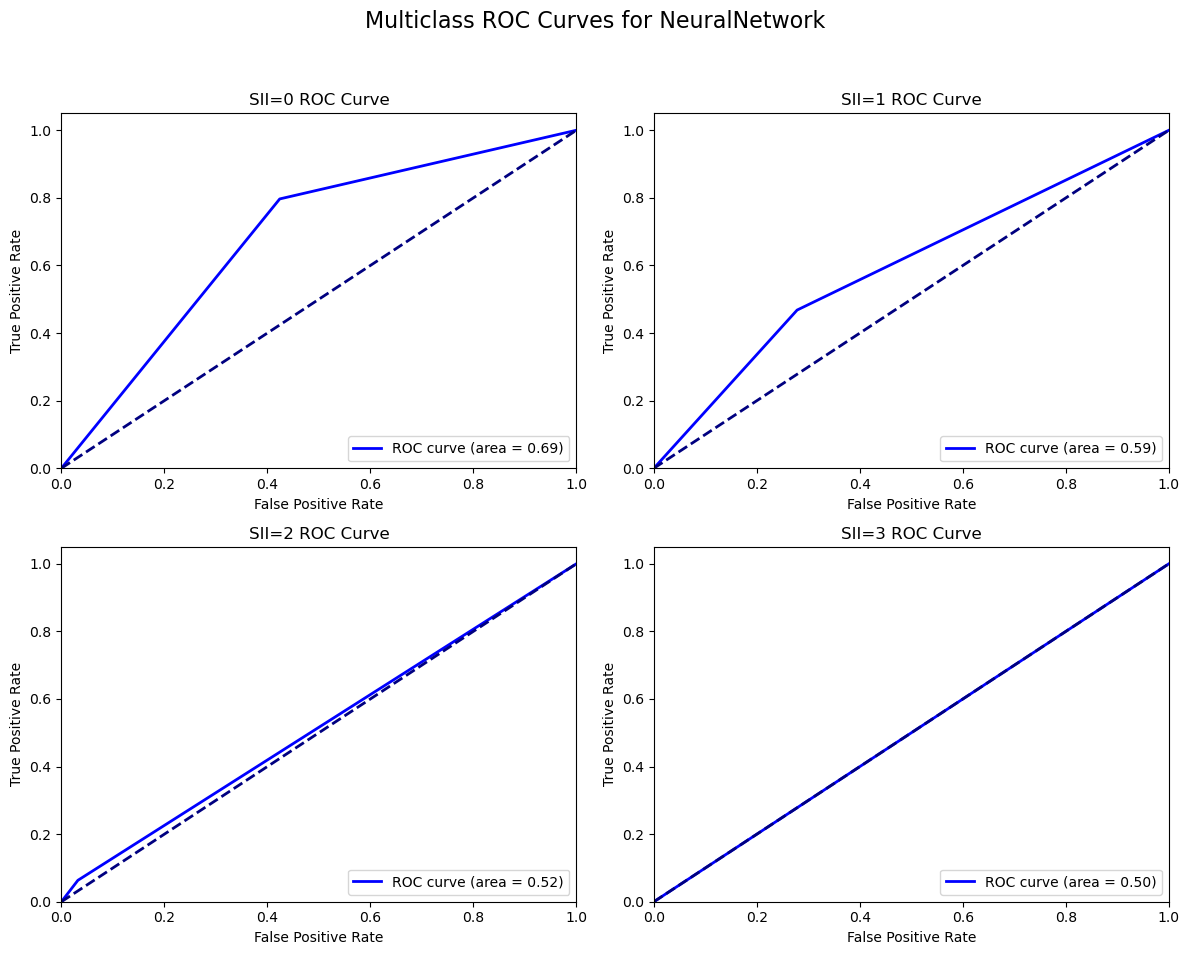

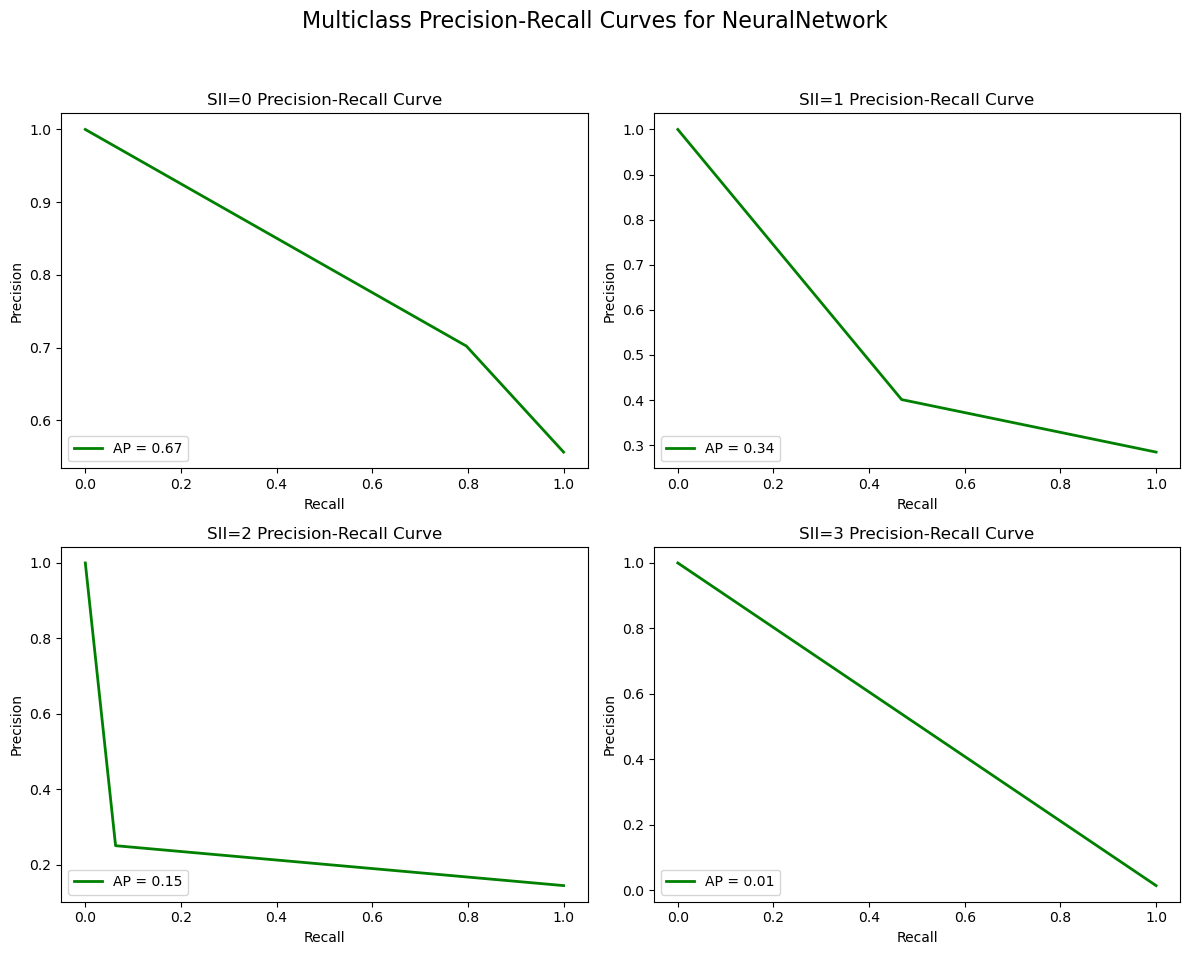


{'LinearRegression': {'best_params': {}, 'best_score': 0.3771450838806909, 'test_score': 0.39912280701754377}, 'ElasticNet': {'best_params': {'alpha': 0.1, 'l1_ratio': 0.9}, 'best_score': 0.39161452498857957, 'test_score': 0.3912158481694904}, 'KNN': {'best_params': {'n_neighbors': 5, 'weights': 'distance'}, 'best_score': 0.3048249556736983, 'test_score': 0.30232617652327454}, 'XGBoost': {'best_params': {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}, 'best_score': 0.38424103535746973, 'test_score': 0.34185317177476826}, 'NeuralNetwork': {'best_params': {'layers': 4, 'layer_sizes': 8, 'activation': 'relu', 'learning_rate': 0.003, 'epochs': 10, 'batch_size': 8}, 'best_score': 0.37891462488706074, 'test_score': 0.39490288598705137}}


In [11]:
# Run the grid search

def manual_grid_search_cv(
    folds: List[FoldData],
    param_grids: Dict[str, Dict[str, List[Any]]]
) -> Dict[str, Dict[str, Any]]:
    results = {}
    
    for model_name, param_grid in param_grids.items():
        print(f"Performing grid search for {model_name}...")
        param_combinations = list(itertools.product(*param_grid.values()))
        param_names = list(param_grid.keys())

        best_score = float("-inf")
        best_params = None

        for param_set in param_combinations:
            params = dict(zip(param_names, param_set))
            fold_scores = []

            for fold in folds:
                train_X, val_X = fold.train_X, fold.val_X
                train_y, val_y = fold.train_y, fold.val_y

                if model_name == "NeuralNetwork":
                    model = NeuralNetwork(**params)
                    model.fit(train_X, train_y.values)
                    predictions = model.predict(val_X)
                # elif model_name == "XGBoost":
                #     model = models[model_name](**params)
                #     model.fit(train_X, train_y.values, eval_set=[(val_X, val_y)], verbose=False)
                #     predictions = model.predict(val_X)
                else:
                    model = models[model_name](**params)
                    model.fit(train_X, train_y.values)
                    predictions = model.predict(val_X)

                val_y_buckets = bucketize(val_y.values)
                pred_buckets = bucketize(predictions)
                qwk = quadratic_weighted_kappa(val_y_buckets, pred_buckets)
                fold_scores.append(qwk)

            mean_qwk = sum(fold_scores) / len(fold_scores)
            print(f"Params: {params}, Mean Val QWK: {mean_qwk}")

            if mean_qwk > best_score:
                best_score = mean_qwk
                best_params = params
        
        # Store the best parameters and scores
        results[model_name] = {
            "best_params": best_params,
            "best_score": best_score
        }
        
        # Evaluate the best model on the test set for each fold
        fold = folds[0] # Test data is the same for all folds
        if model_name == "NeuralNetwork":
            model = NeuralNetwork(**best_params)
            model.fit(train_X_full, train_y_full)
            test_predictions = model.predict(fold.test_X)
        # elif model_name == "XGBoost":
        #     model = models[model_name](**best_params)
        #     model.fit(train_X_full, train_y_full, eval_set=[(fold.test_X, fold.test_y)], verbose=False)
        #     test_predictions = model.predict(fold.test_X)
        else:
            model = models[model_name](**best_params)
            model.fit(train_X_full, train_y_full)
            test_predictions = model.predict(fold.test_X)

        test_y_buckets = bucketize(fold.test_y)
        test_pred_buckets = bucketize(test_predictions)
        test_y_binarized = label_binarize(test_y_buckets, classes=[0, 1, 2, 3])
        test_pred_binarized = label_binarize(test_pred_buckets, classes=[0, 1, 2, 3])
        test_qwk = quadratic_weighted_kappa(test_y_buckets, test_pred_buckets)
        test_rmse = np.sqrt(mean_squared_error(fold.test_y, test_predictions))
        weighted_f1 = f1_score(test_y_buckets, test_pred_buckets, average="weighted")
        # avg_precision = average_precision_score(test_y_buckets, test_pred_buckets, average="weighted")

        print(f"Best Params for {model_name}: {best_params}")
        print(f"Full train QWK: {best_score}, Test QWK: {test_qwk}, Test RMSE: {test_rmse}, Weighted F1 Score: {weighted_f1}\n")
        # print(f"Weighted F1 Score: {weighted_f1}, Average Precision Score: {avg_precision}\n")
        conf_matrix = confusion_matrix(test_y_buckets, test_pred_buckets)
        plt.figure(figsize=(10, 8))
        
        # Create heatmap
        sns.heatmap(
            conf_matrix, 
            annot=True,
            fmt=",d",
            cmap="viridis",
            square=True,
            cbar=True,
            annot_kws={"size": 16},
            linewidths=0.5,
            linecolor="gray")

        cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                plt.text(
                    j + 0.5, i + 0.7, 
                    f"({cm_normalized[i, j]:.1%})",
                    ha="center",
                    va="center",
                    color="black" if cm_normalized[i, j] < 0.5 else "white",
                    fontsize=12
                )
        plt.title(f"Test Confusion Matrix for {model_name}")
        plt.xlabel("Predicted Label", labelpad=10, size=14)
        plt.ylabel("True Label", labelpad=10, size=14)
        plt.savefig(f"figures/{model_name}_confusion_matrix.png", dpi=300)
        plt.show()

        # Multiclass ROC Curve
        plot_multiclass_roc(test_y_binarized, test_pred_binarized, 4, model_name)

        # Multiclass Precision-Recall Curve
        plot_multiclass_precision_recall(test_y_binarized, test_pred_binarized, 4, model_name)
        print()

        results[model_name]["test_score"] = test_qwk
    
    return results


# Put this in a table and bold best for presentation and report
param_grids = {
    "LinearRegression": {},
    "ElasticNet": {
        "alpha": [0.1, 0.5, 1.0],
        "l1_ratio": [0.1, 0.5, 0.9]
    },
    "KNN": {
        "n_neighbors": [3, 5, 10],
        "weights": ["uniform", "distance"]
    },
    "XGBoost": {
        "n_estimators": [50, 100],
        # "max_depth": [10000],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.1, 0.01],
        "subsample": [0.8, 1.0],
        # "colsample_bytree": [0.8, 1.0] # No real impact
        # "early_stopping_rounds": [5] # No real impact
        
    },
    "NeuralNetwork": {
        "layers": [1, 2, 4],
        "layer_sizes": [4, 8],
        "activation": ["relu"],
        "learning_rate": [0.001, 0.003],
        "epochs": [5, 10],
        "batch_size": [8, 16, 32]
    }
}

# Assume `folds` is a list of FoldData objects
results = manual_grid_search_cv(folds, param_grids)
print(results)

**Analysis**

In [12]:
full_processed_X = np.vstack((folds[0].train_X, folds[0].val_X, folds[0].test_X))
full_processed_y = pd.concat([folds[0].train_y, folds[0].val_y, folds[0].test_y])

def avg_perf(X: pd.DataFrame, y: pd.Series, best_models: Dict[str, Any], num_runs: int = 30):
    rmse_perf = {}
    qwk_perf = {}

    for state in tqdm(range(SEED, SEED + num_runs), desc="Evaluating performance"):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=state, stratify=bucketize(y)
        )

        test_y_buckets = bucketize(y_test)
        # print(np.array([0 for _ in range(len(test_y_buckets))]))
        # baseline_qwk = quadratic_weighted_kappa(test_y_buckets, [0 for _ in range(len(test_y_buckets))])
        # print(baseline_qwk)
        # qwk_perf["Baseline"] = qwk_perf.get("Baseline", []) + [baseline_qwk]
        

        for name, model_info in best_models.items():
            if name == "NeuralNetwork":
                model = NeuralNetwork(**model_info["best_params"])
            else:
                model = models[name](**model_info["best_params"])

            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            
            test_pred_buckets = bucketize(predictions)
            # print(test_pred_buckets)
            rmse = np.sqrt(mean_squared_error(y_test, predictions))
            qwk = quadratic_weighted_kappa(test_y_buckets, test_pred_buckets)

            rmse_perf[name] = rmse_perf.get(name, []) + [rmse]
            qwk_perf[name] = qwk_perf.get(name, []) + [qwk]

    return rmse_perf, qwk_perf


rmse_perf, qwk_perf = avg_perf(full_processed_X, full_processed_y, results)
rmse_without_lr_outliers = {key: value for key, value in rmse_perf.items()}
for key in rmse_without_lr_outliers:
    if key == "LinearRegression":
        rmse_without_lr_outliers[key] = [
            val for val in rmse_without_lr_outliers[key] if val < 100
        ]


Evaluating performance: 100%|██████████| 30/30 [00:48<00:00,  1.60s/it]


In [13]:
full_processed_y_mean = full_processed_y.mean()
baseline_rmse = np.sqrt(mean_squared_error(full_processed_y, [full_processed_y_mean for _ in range(len(full_processed_y))]))
print(f"Baseline RMSE: {baseline_rmse}")

Baseline RMSE: 20.33513545785032


## Neural Network Local Importance with SHAP ##

## General Performance ##

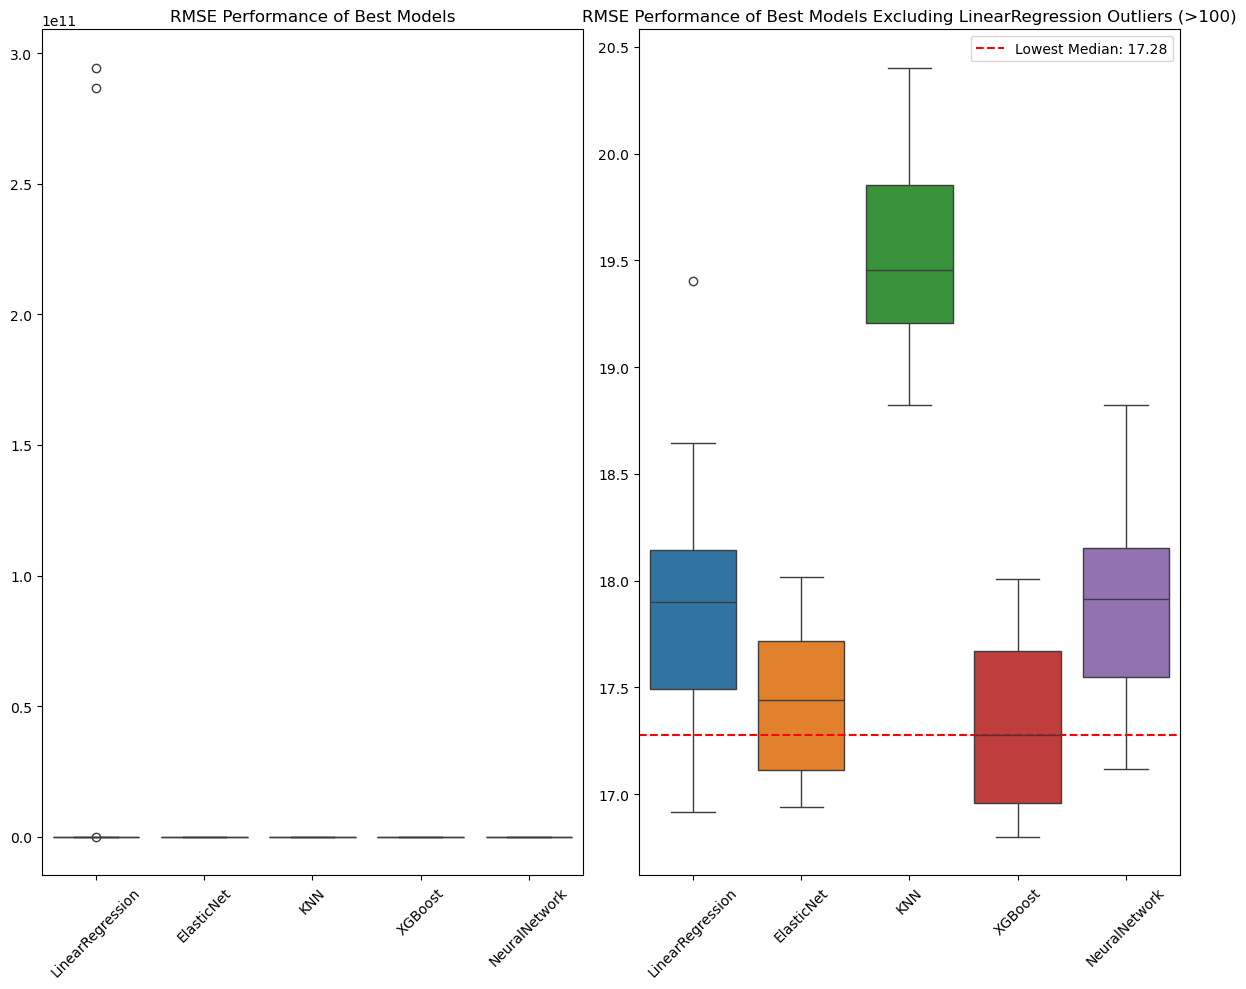

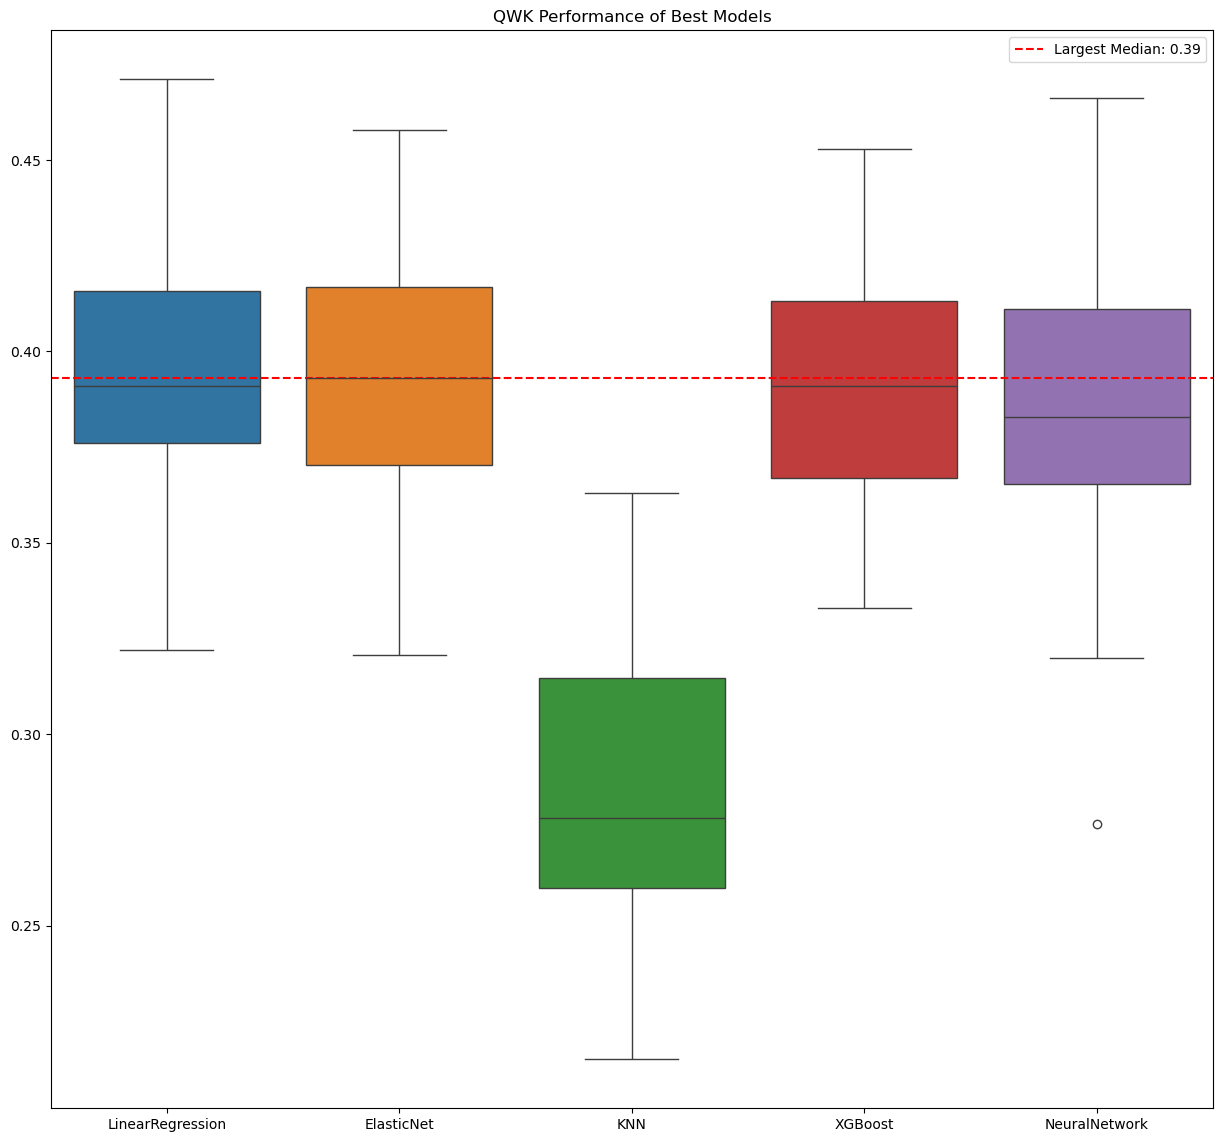

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10))
lowest_median = min([
    np.median(rmse_perf[model]) for model in rmse_perf.keys()
])
sns.boxplot(data=rmse_perf, ax=axes[0])
axes[0].set_title("RMSE Performance of Best Models")
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)
sns.boxplot(data=rmse_without_lr_outliers, ax=axes[1])
plt.axhline(
    y=lowest_median, color="red", linestyle="--",
    linewidth=1.5, label=f"Lowest Median: {lowest_median:.2f}"
)
axes[1].set_title("RMSE Performance of Best Models Excluding LinearRegression Outliers (>100)")
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)
# plt.title("RMSE Performance of Best Models")
plt.legend()
plt.tight_layout()
plt.savefig("figures/rmse_perf.png", dpi=300)
plt.show()

plt.figure(figsize=(15, 14))
largest_median = max([
    np.median(qwk_perf[model]) for model in qwk_perf.keys()
])
sns.boxplot(data=qwk_perf)
plt.axhline(
    y=largest_median, color="red", linestyle="--",
    linewidth=1.5, label=f"Largest Median: {largest_median:.2f}"
)
plt.title("QWK Performance of Best Models")
plt.legend()
plt.savefig("figures/qwk_perf.png", dpi=300)
plt.show()

Permutation Importance for LinearRegression


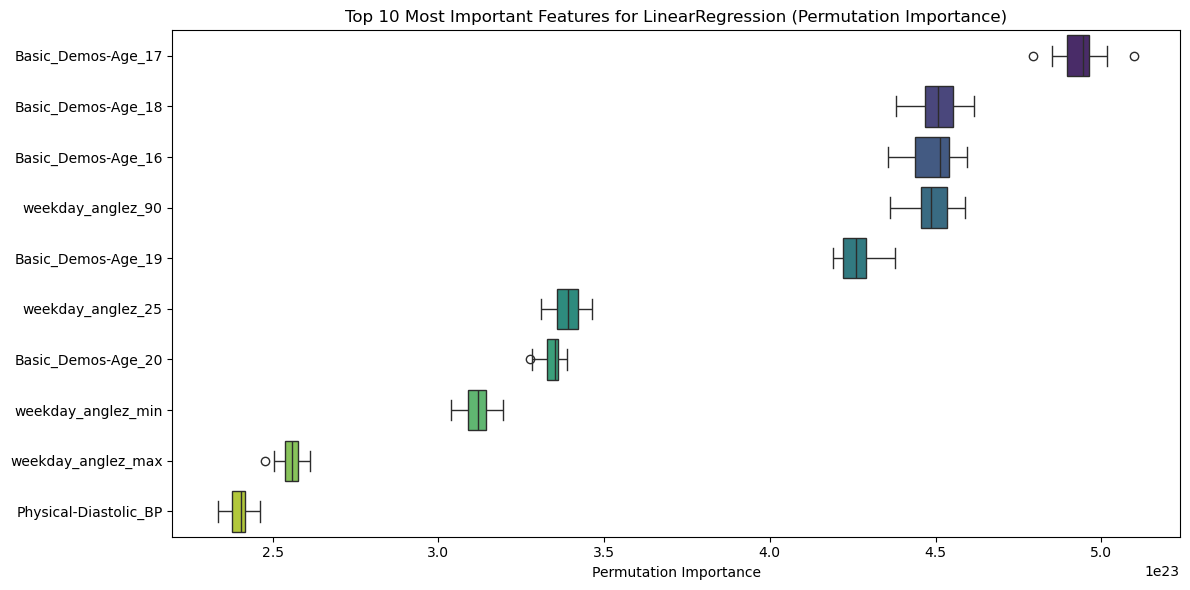

Permutation Importance for ElasticNet


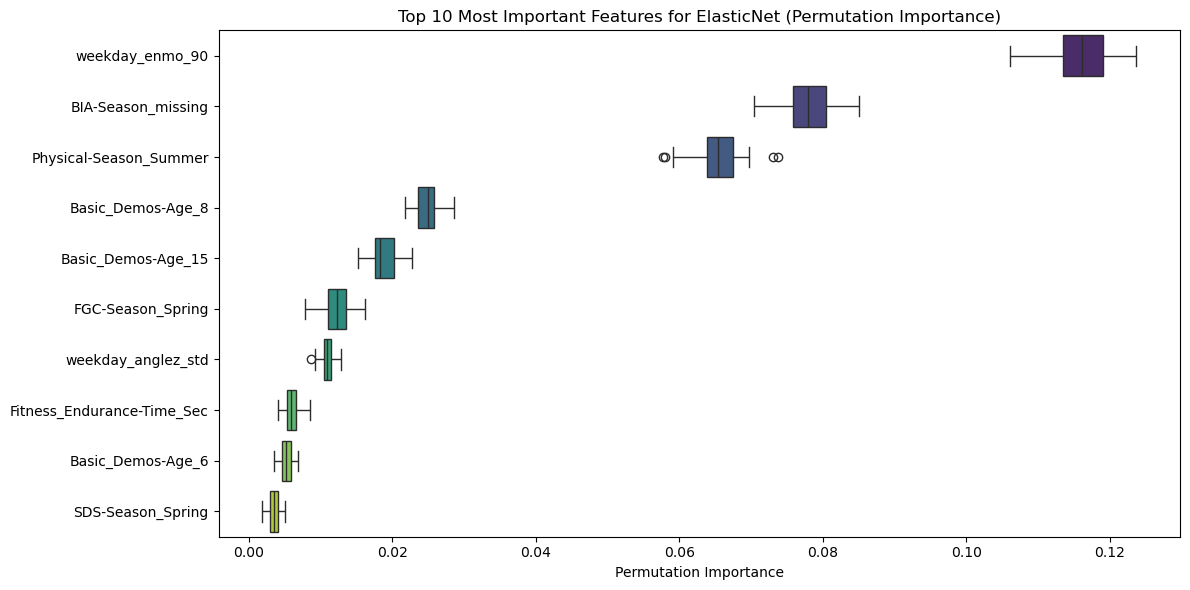

Permutation Importance for KNN


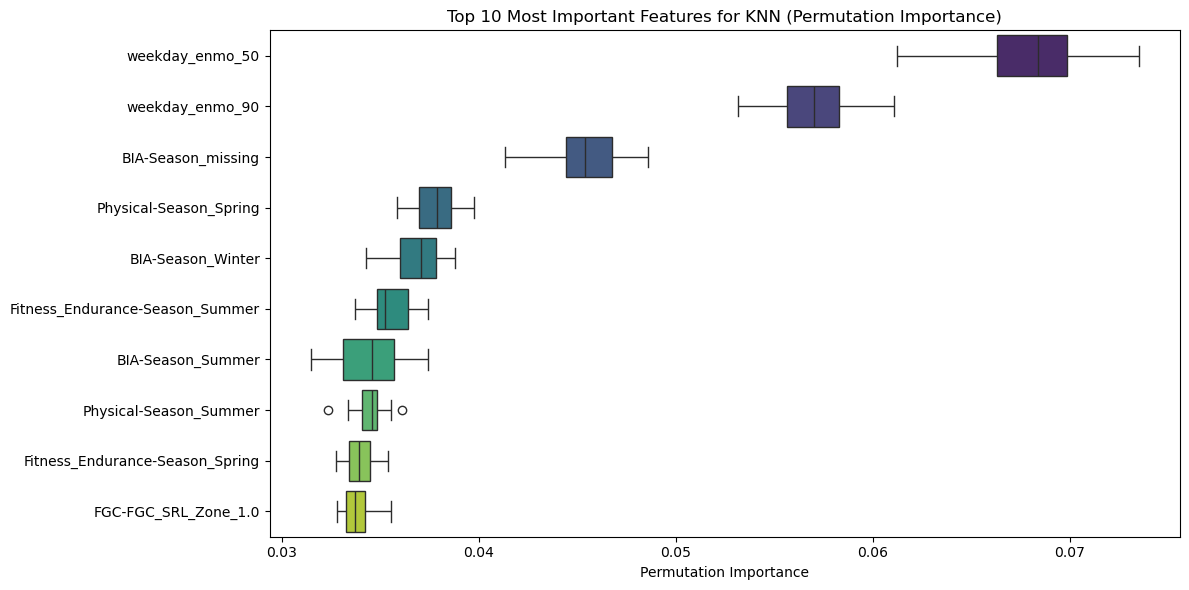

Permutation Importance for XGBoost


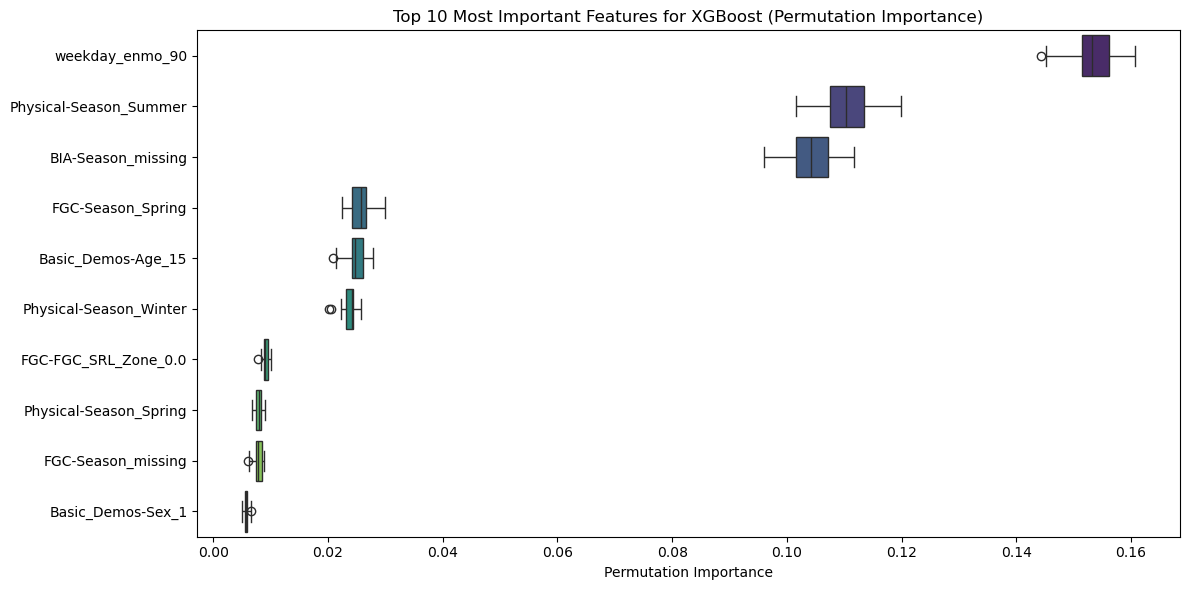

Permutation Importance for NeuralNetwork


/opt/miniconda3/envs/internet_classification/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


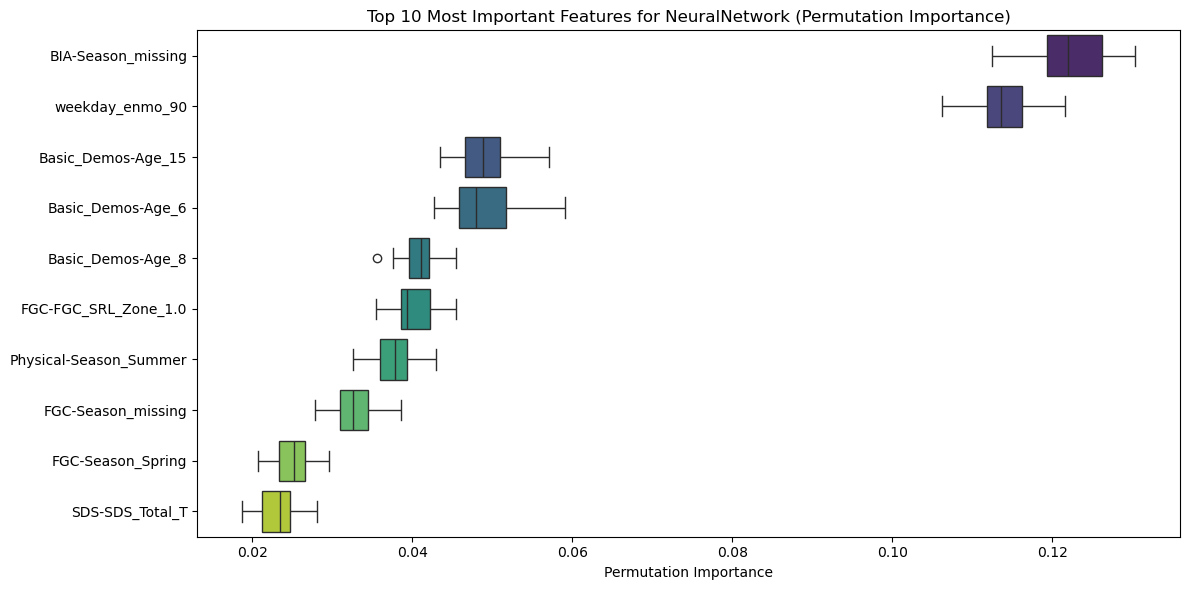

In [15]:

def plot_permutation_importance(
    X: pd.DataFrame,
    y: pd.Series,
    pipeline: ColumnTransformer,
    model: Any,
    top_n: int = 10,
    name: str = "None"
):
    # Preprocess the features
    X_processed = pipeline.fit_transform(X, y)

    # Drop Basic_Demos-Age_14
    one_hot_features = pipeline.named_transformers_["one_hot"].get_feature_names_out(one_hot)
    all_features = list(one_hot_features) + ordinal + min_max + std_scaler
    df_train_transformed = pd.DataFrame(X_processed, columns=all_features, index=X.index)
    df_train_transformed.drop(columns=["Basic_Demos-Age_14"], inplace=True)
    X_processed = df_train_transformed.values
    
    # Fit the model on the processed data
    model.fit(X_processed, y)
    
    # Calculate permutation importance
    result = permutation_importance(model, X_processed, y, n_repeats=30, random_state=42, n_jobs=-10)
    
    # Get the importance scores and their indices
    sorted_idx = result.importances_mean.argsort()[::-1]
    top_n_idx = sorted_idx[:top_n]
    
    # Map indices to feature names
    top_n_features = np.array(list(df_train_transformed.columns))[top_n_idx]
    top_n_importances = result.importances[top_n_idx]
    
    # Plot the box plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=top_n_importances.T, orient='h', palette='viridis')
    plt.yticks(ticks=range(len(top_n_features)), labels=top_n_features)
    plt.xlabel("Permutation Importance")
    plt.title(f"Top {top_n} Most Important Features for {name} (Permutation Importance)")
    plt.tight_layout()
    plt.savefig(f"figures/{name}_permutation_importance.png", dpi=300)
    plt.show()


for name, model in results.items():
    if name == "NeuralNetwork":
        model = NeuralNetwork(**model["best_params"])
    else:
        model = models[name](**model["best_params"])

    print(f"Permutation Importance for {name}")
    transformers = [
        ("min_max", MinMaxScaler(), min_max),
        ("std_scaler", StandardScaler(), std_scaler),
        ("one_hot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), one_hot),
        ("ordinal", OrdinalEncoder(categories=[ORDINAL_FEATURES[col] for col in ordinal]), ordinal)
    ]
    plot_permutation_importance(
        train_X_full_df, train_y_full, ColumnTransformer(transformers),
        model, top_n=10, name=name
    )

**SHAP for 1-2 data points for the best model (neural network)**

In [16]:
transformers = [
    ("min_max", MinMaxScaler(), min_max),
    ("std_scaler", StandardScaler(), std_scaler),
    ("one_hot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), one_hot),
    ("ordinal", OrdinalEncoder(categories=[ORDINAL_FEATURES[col] for col in ordinal]), ordinal)
]
transformer = ColumnTransformer(transformers)

X_train = transformer.fit_transform(train_X_full_df)
y_train = train_y_full
X_test = transformer.transform(folds[0].test_X_df)
y_test = folds[0].test_y

transformed_feature_names = transformer.get_feature_names_out()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
model = NeuralNetwork(**results["NeuralNetwork"]["best_params"])
model.fit(X_train, y_train)

# Initialize SHAP explainer
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

(6564, 140) (6564,) (548, 140) (548,)


PermutationExplainer explainer: 549it [02:02,  4.12it/s]                         


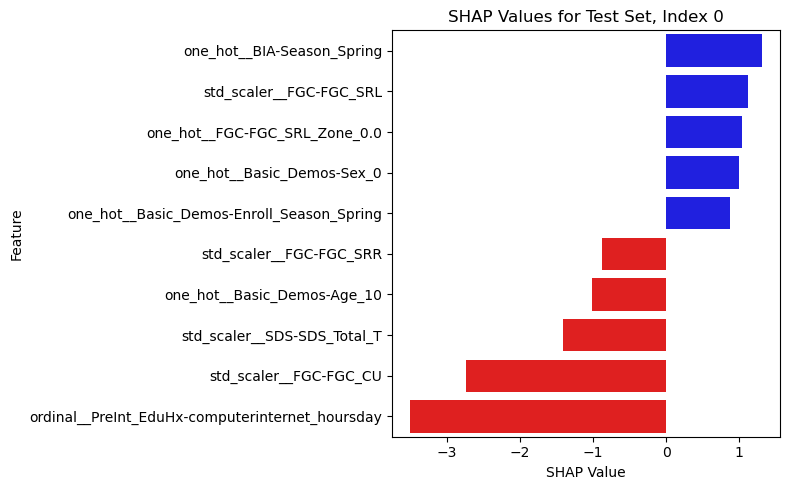

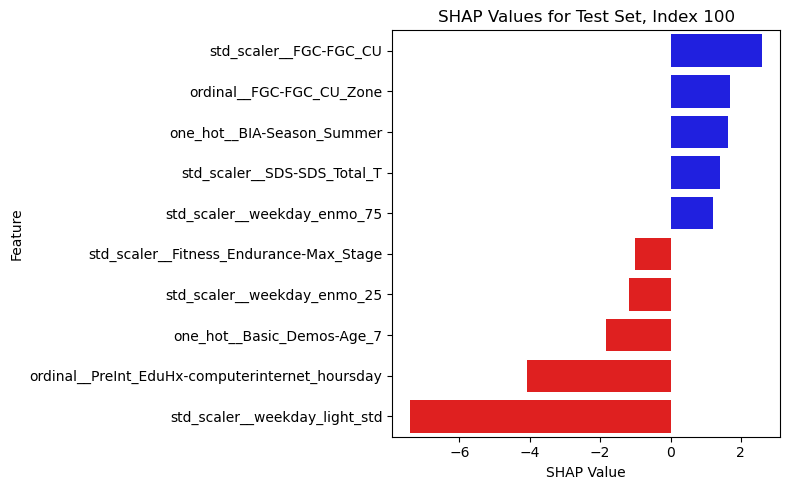

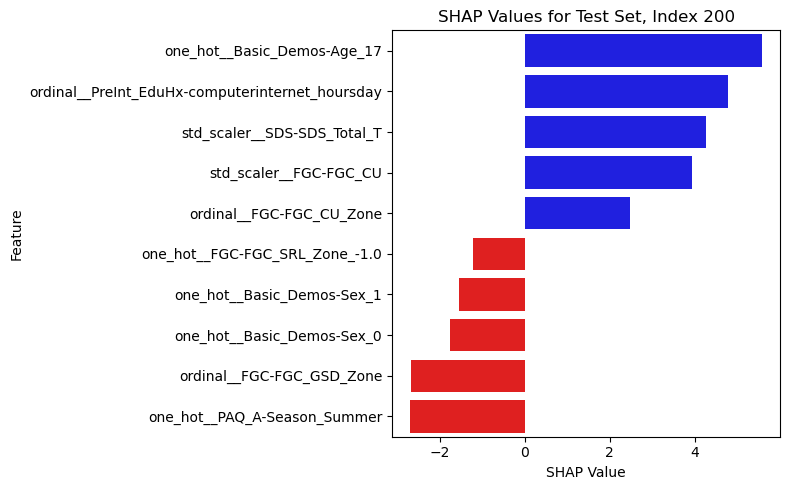

In [17]:
shap_df = pd.DataFrame(shap_values.values, columns=transformed_feature_names)

# Can't use shap.force_plot since the explainer defaults to permutation_explainer
# which can't be used with force_plot.
for i in [0, 100, 200]:
    fig = plt.figure(figsize=(8, 5))
    shap_values_i = shap_values[i]
    shap_df_i = shap_df.iloc[i]
    shap_df_i = shap_df_i.sort_values(ascending=False)
    top_features = shap_df_i.head(5)
    bottom_features = shap_df_i.tail(5)
    features = pd.concat([top_features, bottom_features])
    colors = ["blue" if val > 0 else "red" for val in features]
    
    sns.barplot(x=features, y=features.index, palette=colors)
    plt.title(f"SHAP Values for Test Set, Index {i}")
    plt.xlabel("SHAP Value")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(f"figures/shap_values_{i}.png", dpi=300)
    plt.show()